In [3]:
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# 한글설정
from matplotlib import font_manager
f_path = '/Library/Fonts/NanumGothic.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc


rc('font', family = 'NanumGothic')

# #지수표현 안나오게 하기
# pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.float_format', None)

import folium
from folium.plugins import MarkerCluster, MiniMap

* 제주도 2차 재난지원금 신청: 8. 24. ~ 10. 11.

"""


* YM : 기준년월 
* SIDO : 지역대분류명 
* SIGUNGU : 지역중분류명 
* FranClass : 소상공인구분 
* Type : 업종명 
* Time : 시간대 
* vTotalSpent : 총사용금액 
* DisSpent : 재난지원금 사용금액 
* NumOfSpent : 총 이용건수 
* NumOfDisSpent : 총 재난지원금 이용건수 
* POINT_X, POINT_Y : X,Y 좌표 
* Ts-DS : 총사용금액 - 재난지원금
* NTS-NDS : 총이용건수-총재난금액 이용건수
* Mts : 총사용금액/총이용건수 (의미없어보이지만)
* Mds : 재난지원금/재난지원금 이용건수
* Time_cut : 심야 새벽 오전 점심 오후 저녁 무승인거래


"""


In [4]:
# # 기존에 저장했던 파일 불러오기
# # Time을 str형식으로 지정안하고 불러오니 01,02와 1,2(숫자형식)가 섞여서 출력됨
# df = pd.read_csv('./dacon_jeju.csv', sep=',', dtype = {"Time": str})
# df=df.iloc[:,1:]
# df.info()

In [5]:
# df = pd.read_csv('./data/jeju_dong_category_20201221.csv',  dtype = {"Time": str})
# df.info()

In [6]:
# with open('jeju_dong_cate.pickle','wb') as fw:
#      pickle.dump(df, fw)

In [55]:
with open('jeju_all.pickle', 'rb') as fr:
    jeju_all = pickle.load(fr)

jeju_all.tail(3)

UnpicklingError: invalid load key, 'v'.

In [7]:
with open('jeju_dong_cate.pickle','rb') as fr:
    df = pickle.load(fr)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119429 entries, 0 to 1119428
Data columns (total 21 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1119429 non-null  int64  
 1   OBJECTID       1119429 non-null  int64  
 2   Field1         1119429 non-null  int64  
 3   YM             1119429 non-null  int64  
 4   SIDO           1119429 non-null  object 
 5   SIGUNGU        1119429 non-null  object 
 6   FranClass      1119429 non-null  object 
 7   Type           1119429 non-null  object 
 8   Time           1119429 non-null  object 
 9   TotalSpent     1119429 non-null  int64  
 10  DisSpent       1119429 non-null  int64  
 11  NumofSpent     1119429 non-null  int64  
 12  NumofDisSpent  1119429 non-null  int64  
 13  POINT_X        1119429 non-null  float64
 14  POINT_Y        1119429 non-null  float64
 15  lon            1119429 non-null  float64
 16  lat            1119429 non-null  float64
 17  lon_lat 

In [33]:
df.head()

,Unnamed: 0,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Time_cut,category
0,0,1,1,202005,제주특별자치도,제주시,영세,일반한식,00,363000,66500,10,2,877005.9834,1479766.073,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,심야,외식/주점
1,1,4904,4904,202005,제주특별자치도,제주시,영세,일반한식,01,86500,0,3,0,877005.9834,1479766.073,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,심야,외식/주점
2,2,8569,8569,202005,제주특별자치도,제주시,영세,일반한식,02,208000,0,5,0,877005.9834,1479766.073,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,새벽,외식/주점
3,3,11270,11270,202005,제주특별자치도,제주시,영세,일반한식,03,18000,0,1,0,877005.9834,1479766.073,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,새벽,외식/주점
4,4,19122,19122,202005,제주특별자치도,제주시,중소,한의원,07,4800,0,2,0,877005.9834,1479766.073,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,오전,의료


In [8]:
df_nw = df[df['dong'].str.contains('남원')]
df_ps = df[df['dong'].str.contains('표선')]
df_ss = df[df['dong'].str.contains('성산')]

In [39]:
def df_time(b,c):
    """
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로
    """
    df_temp= df.groupby(['Time','Type'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(10)

In [40]:
# 전체 시간별, 제주도 업종별 상위 10개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,일반한식,1677964446,01,유흥주점,1249479291,02,유흥주점,1007309043,03,유흥주점,653158048,04,유흥주점,379003070,05,편의점,361632160,06,편의점,747650198,07,주유소,1433628112,08,주유소,1967525272,09,유아원,2480693770,10,슈퍼마켓,2724037069,11,일반한식,5573935461,12,일반한식,12985457998,13,일반한식,10097859576,14,일반한식,6669065245,15,일반한식,4271768026,16,슈퍼마켓,4569263198,17,슈퍼마켓,5004479365,18,일반한식,9019257495,19,일반한식,15920911731,20,일반한식,17576860695,21,일반한식,10154166066,22,일반한식,4716514394,23,일반한식,2719021765
1,00,유흥주점,1377319834,01,일반한식,1067636731,02,일반한식,678892520,03,일반한식,435681960,04,편의점,252701189,05,유흥주점,205036410,06,주유소,684430334,07,편의점,1183994930,08,슈퍼마켓,1388544035,09,주유소,2286527782,10,유아원,2685803080,11,슈퍼마켓,2760287062,12,서양음식,2866544773,13,슈퍼마켓,3040643477,14,슈퍼마켓,3435110556,15,슈퍼마켓,3890163693,16,면세점,3566947245,17,일반한식,4355495798,18,슈퍼마켓,5073070850,19,슈퍼마켓,4171381561,20,슈퍼마켓,3381237681,21,편의점,3244907749,22,편의점,2571743018,23,편의점,1757832755
2,00,편의점,1069768561,01,단란주점,749281631,02,단란주점,514091710,03,편의점,317351210,04,일반한식,233843823,05,일반한식,170665661,06,면세점,374592550,07,면세점,1048981340,08,편의점,1360138660,09,슈퍼마켓,2265661918,10,일반한식,2559795563,11,주유소,2473699690,12,슈퍼마켓,2838139019,13,서양음식,2923637873,14,면세점,2820576875,15,면세점,3255753865,16,일반한식,3190884842,17,면세점,2916795642,18,편의점,2652127052,19,편의점,2890278696,20,편의점,3285128081,21,슈퍼마켓,2758434393,22,슈퍼마켓,1725070706,23,유흥주점,1341605578
3,00,단란주점,830214940,01,편의점,679859251,02,편의점,460379818,03,단란주점,221701567,04,단란주점,84479600,05,주유소,148038414,06,골프경기장,328863860,07,슈퍼마켓,766076990,08,면세점,1357449480,09,면세점,1689285439,10,주유소,2433437286,11,면세점,2323183870,12,면세점,2819389960,13,면세점,2710893593,14,서양음식,2668575162,15,주유소,2596786432,16,주유소,2667311935,17,주유소,2659452937,18,주유소,2412772204,19,면세점,2334286847,20,일식회집,2093558089,21,일식회집,1499453688,22,유흥주점,994644534,23,단란주점,824573615
4,00,주점,509761373,01,주점,341764534,02,주점,202897286,03,주점,85962917,04,주유소,68082098,05,슈퍼마켓,82875930,06,일반한식,282537588,07,일반한식,515848481,08,일반한식,850813399,09,일반한식,1550875385,10,면세점,2042548965,11,유아원,2080548570,12,주유소,2356295666,13,주유소,2507035494,14,주유소,2591290597,15,서양음식,2242257603,16,농축협직영매장,2066114416,17,농축협직영매장,2297488453,18,면세점,2368435390,19,서양음식,1878253901,20,면세점,1922705276,21,대형할인점,1230357130,22,서양음식,749275593,23,주점,665867091
5,00,서양음식,321363660,01,서양음식,198590170,02,서양음식,108812830,03,기타숙박업,61122316,04,슈퍼마켓,46345350,05,콘도,51709954,06,슈퍼마켓,249946350,07,골프경기장,486726393,08,유아원,798452610,09,약국,1345630484,10,종합병원,1734857960,11,약국,1642855336,12,골프경기장,2291905588,13,골프경기장,1982682489,14,편의점,1758078300,15,편의점,1859714310,16,편의점,1960194672,17,편의점,2172893751,18,농축협직영매장,2201327840,19,농축협직영매장,1662807450,20,서양음식,1802888783,21,서양음식,1173035696,22,대형할인점,744883620,23,슈퍼마켓,589317316
6,00,인터넷Mall,240513708,01,인터넷Mall,134106140,02,기타숙박업,87150953,03,서양음식,58335890,04,기타숙박업,43602805,05,단란주점,42631100,06,화물운송,115414340,07,유아원,195756820,08,농축협직영매장,535898508,09,편의점,1284002320,10,약국,1649190081,11,서양음식,1627999470,12,편의점,1864684715,13,유아원,1819731050,14,유아원,1683167060,15,농축협직영매장,1786973112,16,대형할인점,1806708670,17,골프경기장,2112369823,18,골프경기장,1778241194,19,주유소,1625906163,20,대형할인점,1384870530,21,스넥,822225189,22,주점,704874820,23,서양음식,487274271
7,00,스넥,209400622,01,기타숙박업,111966230,02,칵테일바,69165300,03,슈퍼마켓,51316040,04,주점,43211750,05,기타숙박업,35700945,06,유흥주점,106507550,07,기타건축자재,190737881,08,종합병원,436501790,09,의원,1157720900,10,의원,1615744544,11,의원,1616866550,12,유아원,1720223620,13,편의점,1737204054,14,농축협직영매장,1570916671,15,대형할인점,1727411440,16,서양음식,1805015416,17,대형할인점,1787452730,18,서양음식,1631287327,19,일식회집,1598813637,20,농축협직영매장,1224768010,21,주유소,639

#### 제주도에서 시간별로 많이 소비되는 업종을 살펴보면
* 새벽시간대에는 주점과 편의점에서 많이 소비된다
* 오전시간대에는 출근 시간대에 주유소에서 사용된다
* 점심시간대와 저녁시간대에서는 한식점에서 많이 소비된다
* 다양한 시간대에에서 면세점 소비가 많이 나타고 총소비금액으로 보자면 골프경기장도 상위권에 속해 있다.

In [42]:
# 전체 시간별, 제주도 업종별 상위 10개 (재난지원금) 사용형태을 보여줌
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('DisSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('DisSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent
0,00,일반한식,66405204,01,일반한식,41359331,02,일반한식,26119291,03,일반한식,17346828,04,편의점,13129282,05,편의점,21747792,06,편의점,42375199,07,주유소,80397642,08,슈퍼마켓,115614892,09,슈퍼마켓,189028719,10,슈퍼마켓,250782446,11,슈퍼마켓,284231227,12,일반한식,703256626,13,일반한식,515350638,14,슈퍼마켓,360608145,15,슈퍼마켓,416251344,16,슈퍼마켓,483340606,17,슈퍼마켓,550507814,18,슈퍼마켓,564824797,19,일반한식,980789240,20,일반한식,1020459187,21,일반한식,498071189,22,일반한식,225442086,23,일반한식,121573102
1,00,편의점,48770766,01,편의점,31685960,02,편의점,23012590,03,편의점,16455323,04,일반한식,8584051,05,일반한식,7510717,06,주유소,34818458,07,편의점,66995954,08,주유소,113388987,09,주유소,147347465,10,농축협직영매장,173656042,11,일반한식,262357014,12,슈퍼마켓,292163611,13,슈퍼마켓,324640860,14,일반한식,275447499,15,농축협직영매장,237849049,16,농축협직영매장,266716671,17,농축협직영매장,280701578,18,일반한식,519295082,19,슈퍼마켓,451666885,20,슈퍼마켓,364546651,21,슈퍼마켓,297906832,22,슈퍼마켓,166041419,23,편의점,77360815
2,00,주점,15592772,01,주점,9685810,02,주점,4778520,03,슈퍼마켓,3780400,04,슈퍼마켓,3474882,05,슈퍼마켓,5759705,06,슈퍼마켓,19010870,07,슈퍼마켓,58564542,08,편의점,74196640,09,농축협직영매장,123026304,10,주유소,154478728,11,농축협직영매장,181768630,12,농축협직영매장,177685366,13,농축협직영매장,185740831,14,농축협직영매장,213046699,15,주유소,165297641,16,스포츠레져용품,165556772,17,일반한식,217531436,18,농축협직영매장,278845296,19,농축협직영매장,198970015,20,편의점,155987788,21,편의점,141619714,22,편의점,111219700,23,슈퍼마켓,52859476
3,00,스넥,10798920,01,서양음식,7321420,02,슈퍼마켓,4560816,03,서양음식,2384380,04,대형할인점,1295350,05,주유소,4131258,06,일반한식,11160797,07,일반한식,23697586,08,농축협직영매장,60091735,09,약국,106665907,10,약국,134425259,11,주유소,149513862,12,주유소,140017426,13,주유소,152896528,14,주유소,166287853,15,스포츠레져용품,163588519,16,주유소,158224089,17,주유소,159331027,18,편의점,148410880,19,편의점,149169882,20,농축협직영매장,146502198,21,농축협직영매장,74408388,22,스넥,44123218,23,스넥,26219584
4,00,서양음식,9981928,01,슈퍼마켓,5746156,02,서양음식,2846600,03,주점,1883130,04,주점,953210,05,스포츠레져용품,1697930,06,LPG,3310828,07,LPG,11112464,08,일반한식,36676473,09,의원,77863180,10,의원,98856186,11,약국,128499300,12,서양음식,111138815,13,스포츠레져용품,120653376,14,스포츠레져용품,160091435,15,일반한식,160686430,16,일반한식,135452763,17,농협하나로클럽,143786348,18,주유소,143989675,19,스포츠레져용품,112396225,20,일식회집,93518476,21,스넥,57952158,22,서양음식,30407468,23,주점,23772515
5,00,슈퍼마켓,9493424,01,스넥,4157191,02,기타숙박업,2108000,03,대형할인점,1502230,04,종합병원,713090,05,사우나,1432080,06,사우나,3229400,07,농축협직영매장,8972840,08,농협하나로클럽,26496240,09,편의점,74508881,10,농협하나로클럽,93406102,11,의원,105838534,12,편의점,106398297,13,서양음식,109552413,14,농협하나로클럽,121593727,15,농협하나로클럽,126885900,16,농협하나로클럽,133727820,17,스포츠레져용품,137550254,18,농협하나로클럽,125409437,19,서양음식,99658582,20,서양음식,90591948,21,서양음식,56639704,22,주점,25523562,23,서양음식,16142356
6,00,일식회집,5099200,01,일식회집,3841940,02,종합병원,1998450,03,기타숙박업,996853,04,기타숙박업,625000,05,종합병원,1361540,06,스포츠레져용품,3132477,07,농축수산품,7983520,08,약국,23738910,09,농협하나로클럽,62649634,10,일반한식,90926872,11,농협하나로클럽,101622332,12,스포츠레져용품,99851707,13,농협하나로클럽,105409843,14,약국,111099767,15,편의점,109219257,16,편의점,115811015,17,편의점,126770243,18,스포츠레져용품,125389228,19,주유소,90775614,20,스포츠레져용품,90562690,21,일식회집,56316732,22,일식회집,20662003,23,일식회집,11330115
7,00,대형할인점,3022150,01,기타숙박업,1958060,02,대형할인점,1629250,03,종합병원,839930,04,스넥,550000,05,대형할인점,1313780,06,화물운송,2683298,07,제과점,6788182,08,종합병원,23394005,09,일반한식,60986688,10,종합병원,83677217,11,편의점,83083955,12,농협하나로클럽,98602056,13,편의점,104832692,14,편의점,103816586,15,약국,106616834,16,약국,98153518,17,약국,81862689,18,스넥,73541474,19,농협하나로클럽,86548712,20,농협하나로클럽,75311572,21,농협하나로클럽,49999093,22,제과점,10905569,23,보습학원,4611780
8,00,볼링장,2364897,01,대형할인점,1482831,02,스넥,1291710,03,기타레져업,818930,04,서양음식,463990,05,기타숙박업,1078720,06,종합병원,1881660,07,비료농약사료종자,5755654,08,농축수산품,19170532,09,종합병원,58874374,10,편의점,76152719,11,스포츠레져용

#### 제주도에서 시간별로 재난지원금 사용행태를 업종으로 살펴보면
* 새벽시간대에는 주점과 편의점에서, 출근 시간대에 주유소에서 사용된다
* 점심시간대와 저녁시간대에서는 한식점에서 많이 소비되며 특정시간을 제외하면 슈퍼마켓에서 주로 재난지원금이 사용된다.

In [36]:
def df_time(a,b,c):
    """a는 제주시 or 서귀포시 하나를 입력
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로"""
    df_temp= df[df['SIGUNGU']==a].groupby(['Time','Type'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(10)

In [37]:
# 전체 시간별, 제주시 업종별 상위 10개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('제주시', 'TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('제주시', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,일반한식,1407801782,01,일반한식,901702835,02,유흥주점,688764033,03,유흥주점,479139740,04,유흥주점,280344200,05,편의점,268270250,06,편의점,543819058,07,면세점,1046321630,08,면세점,1355853960,09,유아원,1870278720,10,유아원,2075022350,11,일반한식,3954555083,12,일반한식,9221923097,13,일반한식,7032846076,14,일반한식,4618427997,15,일반한식,3012713924,16,슈퍼마켓,3357530548,17,슈퍼마켓,3769325007,18,일반한식,6235889437,19,일반한식,10959197456,20,일반한식,12547319323,21,일반한식,7508008347,22,일반한식,3675093817,23,일반한식,2218848821
1,00,유흥주점,929235134,01,유흥주점,859121591,02,일반한식,588921004,03,일반한식,374921560,04,일반한식,198593723,05,유흥주점,168783700,06,주유소,485398650,07,주유소,989042044,08,주유소,1339859731,09,면세점,1689285439,10,슈퍼마켓,1998628582,11,면세점,2112373240,12,면세점,2579277960,13,면세점,2446405193,14,면세점,2538693895,15,면세점,2981672465,16,면세점,3320759775,17,일반한식,3111728608,18,슈퍼마켓,3866072300,19,슈퍼마켓,3200943449,20,슈퍼마켓,2625495880,21,슈퍼마켓,2183226206,22,편의점,1774343518,23,편의점,1255976865
2,00,편의점,801763750,01,단란주점,601556518,02,단란주점,415872700,03,편의점,244301900,04,편의점,192252569,05,일반한식,145814640,06,면세점,374407590,07,편의점,858303420,08,슈퍼마켓,981474048,09,슈퍼마켓,1631347143,10,면세점,1943990435,11,슈퍼마켓,2021154729,12,슈퍼마켓,2056531844,13,슈퍼마켓,2229145753,14,슈퍼마켓,2493873870,15,슈퍼마켓,2825773399,16,일반한식,2326374246,17,면세점,2698222642,18,면세점,2208141510,19,면세점,2334252197,20,편의점,2220891771,21,편의점,2183091258,22,슈퍼마켓,1377890608,23,유흥주점,870942200
3,00,단란주점,655288940,01,편의점,518121921,02,편의점,351621358,03,단란주점,175273567,04,주유소,67770498,05,주유소,124323044,06,일반한식,234842688,07,슈퍼마켓,535214330,08,편의점,967745290,09,주유소,1557477186,10,일반한식,1905421039,11,주유소,1680136102,12,서양음식,1904271135,13,서양음식,1906939763,14,주유소,1762567148,15,주유소,1786282683,16,주유소,1845681855,17,주유소,1834965231,18,편의점,1847333572,19,편의점,1976539959,20,면세점,1922705276,21,일식회집,946137288,22,유흥주점,642935834,23,단란주점,638476500
4,00,주점,399844313,01,주점,266667194,02,주점,157748150,03,주점,68931917,04,단란주점,61494600,05,슈퍼마켓,73631960,06,슈퍼마켓,175002290,07,일반한식,392307441,08,일반한식,616994529,09,약국,1149124957,10,주유소,1656503444,11,유아원,1610329700,12,주유소,1625505222,13,주유소,1739621121,14,서양음식,1710789973,15,서양음식,1419086917,16,편의점,1387477318,17,편의점,1520590089,18,주유소,1701920991,19,서양음식,1251589976,20,일식회집,1298255110,21,서양음식,815924216,22,주점,541003758,23,주점,516129188
5,00,서양음식,252106710,01,서양음식,165690430,02,서양음식,92690990,03,슈퍼마켓,51316040,04,슈퍼마켓,44333930,05,단란주점,26316100,06,골프경기장,162541240,07,골프경기장,266200742,08,유아원,583405690,09,일반한식,1121797105,10,종합병원,1624209070,11,종합병원,1410255711,12,골프경기장,1428912388,13,유아원,1432348840,14,유아원,1314649820,15,편의점,1315667980,16,유아원,1233818270,17,골프경기장,1269472464,18,농축협직영매장,1127878060,19,주유소,1168850699,20,서양음식,1219670434,21,대형할인점,786027880,22,서양음식,526932408,23,슈퍼마켓,509511671
6,00,인터넷Mall,240513708,01,인터넷Mall,134106140,02,기타숙박업,66801708,03,서양음식,51104390,04,주점,34965550,05,기타숙박업,25634397,06,화물운송,115288840,07,기타건축자재,154535232,08,렌트카,424367835,09,종합병원,981002920,10,약국,1403301953,11,약국,1386428186,12,유아원,1359970940,13,편의점,1240630600,14,편의점,1242114682,15,유아원,1230003090,16,서양음식,1171798705,17,농축협직영매장,1206103663,18,서양음식,1087807096,19,일식회집,980927860,20,대형할인점,894857880,21,스넥,572945909,22,단란주점,516894890,23,인터넷Mall,409874427
7,00,항공사,207568300,01,항공사,101958200,02,슈퍼마켓,66418500,03,기타숙박업,51077137,04,기타숙박업,34391285,05,인터넷Mall,24885807,06,유흥주점,87957050,07,유아원,134468830,08,종합병원,412144620,09,의원,971633270,10,의원,1362345894,11,의원,1344418590,12,편의점,1344125545,13,골프경기장,1216685771,14,약국,1147712231,15,대형할인점,1084144050,16,대형할인점,1125060670,17,대형할인점,1118279280,18,골프경기장,1085152038,19,농축협직영매장,888798030,20,주유소,755113800,21,주유소,510361922,22,인터넷Mall,504076981,23,서양음식,35

In [38]:
# 전체 시간별, 서귀포시 업종별 상위 10개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('서귀포시', 'TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('서귀포시', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,유흥주점,448084700,01,유흥주점,390357700,02,유흥주점,318545010,03,유흥주점,174018308,04,유흥주점,98658870,05,편의점,93361910,06,편의점,203831140,07,주유소,444586068,08,주유소,627665541,09,주유소,729050596,10,콘도,827864238,11,일반한식,1619380378,12,일반한식,3763534901,13,일반한식,3065013500,14,일반한식,2050637248,15,일반한식,1259054102,16,슈퍼마켓,1211732650,17,일반한식,1243767190,18,일반한식,2783368058,19,일반한식,4961714275,20,일반한식,5029541372,21,일반한식,2646157719,22,일반한식,1041420577,23,편의점,501855890
1,00,일반한식,270162664,01,일반한식,165933896,02,편의점,108758460,03,편의점,73049310,04,편의점,60448620,05,콘도,41427954,06,주유소,199031684,07,편의점,325691510,08,슈퍼마켓,407069987,09,슈퍼마켓,634314775,10,주유소,776933842,11,특급호텔,927546983,12,서양음식,962273638,13,서양음식,1016698110,14,서양음식,957785189,15,슈퍼마켓,1064390294,16,농축협직영매장,986288964,17,슈퍼마켓,1235154358,18,슈퍼마켓,1206998550,19,슈퍼마켓,970438112,20,편의점,1064236310,21,편의점,1061816491,22,편의점,797399500,23,일반한식,500172944
2,00,편의점,268004811,01,편의점,161737330,02,단란주점,98219010,03,일반한식,60760400,04,콘도,38188611,05,유흥주점,36252710,06,골프경기장,166322620,07,슈퍼마켓,230862660,08,편의점,392393370,09,유아원,610415050,10,특급호텔,739324647,11,콘도,820067078,12,골프경기장,862993200,13,슈퍼마켓,811497724,14,슈퍼마켓,941236686,15,서양음식,823170686,16,일반한식,864510596,17,농축협직영매장,1091384790,18,농축협직영매장,1073449780,19,편의점,913738737,20,일식회집,795302979,21,슈퍼마켓,575208187,22,유흥주점,351708700,23,유흥주점,470663378
3,00,단란주점,174926000,01,단란주점,147725113,02,일반한식,89971516,03,단란주점,46428000,04,일반한식,35250100,05,일반한식,24851021,06,슈퍼마켓,74944060,07,골프경기장,220525651,08,콘도,250740236,09,콘도,504106218,10,슈퍼마켓,725408487,11,주유소,793563588,12,슈퍼마켓,781607175,13,주유소,767414373,14,주유소,828723449,15,농축협직영매장,814371790,16,주유소,821630080,17,골프경기장,842897359,18,편의점,804793480,19,농축협직영매장,774009420,20,슈퍼마켓,755741801,21,일식회집,553316400,22,슈퍼마켓,347180098,23,단란주점,186097115
4,00,주점,109917060,01,주점,75097340,02,주점,45149136,03,콘도,28122956,04,단란주점,22985000,05,주유소,23715370,06,콘도,58520649,07,일반한식,123541040,08,농축협직영매장,246258410,09,농축협직영매장,465774964,10,일반한식,654374524,11,슈퍼마켓,739132333,12,주유소,730790444,13,골프경기장,765996718,14,농축협직영매장,723718486,15,주유소,810503749,16,대형할인점,681648000,17,주유소,824487706,18,주유소,710851213,19,서양음식,626663925,20,서양음식,583218349,21,대형할인점,444329250,22,대형할인점,270742310,23,주점,149737903
5,00,서양음식,69256950,01,서양음식,32899740,02,콘도,20585297,03,주점,17031000,04,기타숙박업,9211520,05,단란주점,16315000,06,일반한식,47694900,07,콘도,114769080,08,일반한식,233818870,09,일반한식,429078280,10,농축협직영매장,638125868,11,골프경기장,665970532,12,편의점,520559170,13,농축협직영매장,610617919,14,특급호텔,598786738,15,대형할인점,643267390,16,서양음식,633216711,17,대형할인점,669173450,18,골프경기장,693089156,19,일식회집,617885777,20,농축협직영매장,547649320,21,서양음식,357111480,22,일식회집,227363700,23,스넥,132711190
6,00,스넥,56404905,01,기타숙박업,25139222,02,기타숙박업,20349245,03,기타숙박업,10045179,04,주점,8246200,05,스포츠레져용품,12894800,06,유흥주점,18550500,07,유아원,61287990,08,유아원,215046920,09,편의점,381238690,10,유아원,610780730,11,농축협직영매장,603395186,12,농축협직영매장,511262292,13,편의점,496573454,14,대형할인점,551790780,15,콘도,618344080,16,편의점,572717354,17,편의점,652303662,18,대형할인점,619380710,19,대형할인점,539525550,20,대형할인점,490012650,21,스넥,249279280,22,서양음식,222343185,23,서양음식,129287200
7,00,기타숙박업,40934196,01,스넥,19981300,02,서양음식,16121840,03,특급호텔,8203676,04,스포츠레져용품,4120000,05,골프경기장,11044580,06,스포츠레져용품,18242200,07,서양음식,54278838,08,특급호텔,123223431,09,특급호텔,303269509,10,편의점,390304320,11,서양음식,585960365,12,농축수산품,483559630,13,대형할인점,474230920,14,편의점,515963618,15,편의점,544046330,16,골프경기장,511600711,17,서양음식,525398701,18,서양음식,543480231,19,주유소,457055464,20,농축수산품,320648720,21,유흥주점,245467500,22,스넥,193958480,23,일식회집,89813000
8,00,일식회집,36040200,01,일식회집,15627400,02,스넥,7939300,03,서양음식,72315

In [ ]:
#### 제주시와 서귀포시의 시간별 총 사용금액을 업종별로 비교해보면
* 크게차이는 없지만(일반한식, 슈퍼마켓 등 먹기리가 상위권을 차지)
* 제주시는 면세점이 총 소비의 상위권을 차지하고 있으며 종합병원, 의원도 보인다.
* 서귀포시는 특급호텔, 골프경기장, 콘도가 눈에 띄게 나타남

In [44]:
def df_time(a,b,c):
    """a는 동이름 중 하나를 입력
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로"""
    df_temp= df[df['dong']==a].groupby(['Time','Type'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(15)

In [45]:
# 전체 시간별, 남원읍 상위 15개 총사용금액을 보여줌(총사용금액)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('남원읍', 'TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('남원읍', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,유흥주점,14135000,01,유흥주점,12560000,02,유흥주점,9211000.0,03,편의점,2341480.0,04,편의점,2444480.0,05,콘도,8532755,06,콘도,18923005,07,주유소,48773881,08,콘도,76518932,09,콘도,138217452,10,콘도,187285303,11,골프경기장,191513334,12,골프경기장,294925680,13,골프경기장,230403603,14,농축협직영매장,95135836,15,콘도,122208168,16,골프경기장,219213481,17,골프경기장,393002474,18,골프경기장,267106162,19,일반한식,215436600,20,일반한식,216883930,21,일반한식,88392500,22,편의점,34468050,23,편의점,20758510
1,00,단란주점,12800000,01,단란주점,10420010,02,편의점,3844150.0,03,유흥주점,1690000.0,04,콘도,1827030.0,05,편의점,5910910,06,편의점,17183880,07,콘도,27780000,08,주유소,62403216,09,농축협직영매장,76774885,10,농축협직영매장,87837248,11,콘도,124695914,12,일반한식,264725711,13,일반한식,161885960,14,일반한식,90028050,15,농축협직영매장,105597130,16,농축협직영매장,129415084,17,농축협직영매장,148815710,18,농축협직영매장,152149610,19,농축협직영매장,104286630,20,콘도,74285838,21,콘도,52710927,22,콘도,28577592,23,단란주점,16688000
2,00,편의점,10439680,01,편의점,6296080,02,단란주점,3690000.0,03,주점,1064000.0,04,일반한식,455000.0,05,골프경기장,1086680,06,주유소,15790960,07,편의점,23667580,08,농축협직영매장,57367090,09,주유소,72242883,10,주유소,80342624,11,일반한식,97468700,12,농축협직영매장,76712502,13,농축협직영매장,82410568,14,골프경기장,79763262,15,골프경기장,71641588,16,콘도,118090444,17,주유소,79294061,18,일반한식,107181713,19,콘도,52349921,20,농축협직영매장,72960910,21,편의점,46655930,22,일반한식,27045250,23,유흥주점,15040000
3,00,콘도,5547970,01,주점,3173500,02,주점,1526500.0,03,단란주점,550000.0,04,골프경기장,373491.0,05,주유소,939017,06,슈퍼마켓,11656470,07,농축협직영매장,22514162,08,편의점,27561870,09,유아원,64605210,10,골프경기장,66655759,11,농축협직영매장,88237206,12,주유소,62943321,13,주유소,76495326,14,콘도,72949587,15,주유소,70689520,16,주유소,72510768,17,콘도,74077672,18,주유소,61769171,19,편의점,49805280,20,편의점,50951050,21,일식회집,29310500,22,단란주점,15515000,23,콘도,10005814
4,00,주점,3559300,01,서양음식,1741000,02,서양음식,1272500.0,03,서양음식,464000.0,04,주유소,301600.0,05,스포츠레져용품,839000,06,골프경기장,11262850,07,골프경기장,20472550,08,골프경기장,17439104,09,골프경기장,29878828,10,유아원,52494350,11,주유소,76055226,12,콘도,58980144,13,서양음식,51384470,14,주유소,70743367,15,일반한식,51614950,16,일반한식,31961000,17,일반한식,50441300,18,콘도,56465282,19,주유소,38609093,20,일식회집,42552500,21,슈퍼마켓,19231500,22,유흥주점,14435000,23,일반한식,9018400
5,00,일반한식,3051500,01,기타숙박업,1416000,02,기타숙박업,667000.0,03,주유소,412554.0,04,기타숙박업,246000.0,05,슈퍼마켓,496660,06,목재석재철물,3374300,07,슈퍼마켓,13554890,08,목재석재철물,15923500,09,편의점,23555750,10,일반한식,27058516,11,유아원,42594170,12,서양음식,51022410,13,농축수산품,34447556,14,서양음식,45059120,15,서양음식,34919870,16,편의점,28693740,17,편의점,33229370,18,편의점,44338130,19,일식회집,30747000,20,서양음식,24138980,21,단란주점,16610000,22,스넥,9440200,23,스넥,5929700
6,00,기타숙박업,2846500,01,일반한식,1279500,02,일반한식,527000.0,03,일반한식,274000.0,04,유흥주점,150000.0,05,헬스크럽,260000,06,골프용품,2253000,07,목재석재철물,8998700,08,슈퍼마켓,9850560,09,농축수산품,20282100,10,치과의원,26268590,11,편의점,25816200,12,편의점,31044970,13,콘도,29855991,14,농축수산품,27764560,15,편의점,27090940,16,농축수산품,27527220,17,슈퍼마켓,29677480,18,슈퍼마켓,33540640,19,골프경기장,29581923,20,슈퍼마켓,22961280,21,서양음식,13229580,22,일식회집,9062000,23,주점,4471600
7,00,서양음식,2450500,01,노래방,647000,02,주유소,462132.0,03,기타숙박업,257000.0,04,주점,108000.0,05,유아원,240000,06,일반한식,1446300,07,농축수산품,6296200,08,비료농약사료종자,9466510,09,비료농약사료종자,17094935,10,편의점,23556600,11,서양음식,22001610,12,농축수산품,27132969,13,편의점,28986180,14,편의점,26754180,15,농축수산품,25592440,16,서양음식,26992020,17,농축수산품,26952131,18,서양음식,23214280,19,서양음식,27156310,20,주유소,18783176,21,스넥,11541600,22,슈퍼마켓,7338880,23,기타숙박업,3973126
8,00,농축수산품,2000000,01,주유소,560090,02,골프경기장,405000.0,03,기타음료식품,12000.0,04,기타음료식품,31000.0,05,일반한식,99000,06,스넥,995000,07,비료농약사료종자,4504510,08,기능학원,8581000,09,일반한식,16633800,10,슈퍼마켓,17138440,11,문화취미기타,19303200,12,유아원,22952900,13,슈퍼마켓,25839630,14,문화취

In [46]:
# 전체 시간별, 남원읍 상위 15개 총사용금액을 보여줌  
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('남원읍', 'DisSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('남원읍', 'DisSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent
0,00,편의점,529620,01,편의점,325110,02,편의점,410000.0,03,편의점,205346.0,04,일반한식,247250.0,05,편의점,464940,06,편의점,1622670,07,주유소,3638695,08,농축협직영매장,7636810,09,농축협직영매장,9626490,10,농축협직영매장,16402558,11,농축협직영매장,14541310,12,일반한식,22137763,13,농축협직영매장,12321820,14,농축협직영매장,12814989,15,농축협직영매장,16705574,16,농축협직영매장,20985085,17,농축협직영매장,22004820,18,농축협직영매장,22189439,19,일반한식,15661540,20,일반한식,16998840,21,일반한식,4871890,22,일반한식,1655780,23,편의점,1121490
1,00,주점,172700,01,주유소,80000,02,서양음식,320000.0,03,주유소,22054.0,04,편의점,122500.0,05,슈퍼마켓,94120,06,슈퍼마켓,1161040,07,농축협직영매장,2845200,08,주유소,5064620,09,주유소,6107536,10,주유소,5702430,11,주유소,7058030,12,농축협직영매장,12037290,13,일반한식,11776520,14,주유소,6142295,15,주유소,6767570,16,주유소,6810699,17,주유소,6405220,18,일반한식,8790263,19,농축협직영매장,14859948,20,농축협직영매장,10859140,21,슈퍼마켓,2496370,22,편의점,1327150,23,일반한식,467000
2,00,일식회집,119000,01,서양음식,20000,02,주유소,80000.0,03,서양음식,0.0,04,골프경기장,0.0,05,스포츠레져용품,61000,06,주유소,786591,07,편의점,1913560,08,편의점,2447590,09,편의점,2539700,10,슈퍼마켓,2695610,11,일반한식,6689830,12,주유소,5098950,13,주유소,6600240,14,일반한식,4202635,15,슈퍼마켓,2494770,16,슈퍼마켓,3362930,17,슈퍼마켓,4259380,18,슈퍼마켓,4561470,19,주유소,3706149,20,편의점,2895000,21,편의점,1908020,22,슈퍼마켓,803040,23,주점,319200
3,00,콘도,94000,01,콘도,0,02,주점,57860.0,03,기타숙박업,0.0,04,기타숙박업,0.0,05,골프경기장,0,06,목재석재철물,226850,07,슈퍼마켓,1312490,08,농축수산품,1634380,09,슈퍼마켓,2421450,10,목재석재철물,1824170,11,정육점,2364060,12,편의점,2499630,13,편의점,2712580,14,슈퍼마켓,2362892,15,편의점,2303660,16,자동차정비,2108440,17,일반한식,4155660,18,주유소,4264630,19,편의점,3691674,20,슈퍼마켓,2313530,21,스넥,913300,22,스넥,496640,23,스넥,283300
4,00,주유소,70000,01,골프경기장,0,02,기타음료식품,0.0,03,기타음료식품,0.0,04,기타음료식품,0.0,05,LPG,0,06,LPG,110000,07,목재석재철물,886270,08,슈퍼마켓,1528910,09,목재석재철물,1651200,10,농축수산품,1806880,11,슈퍼마켓,1916620,12,서양음식,2080964,13,슈퍼마켓,2686680,14,치과의원,2050300,15,일반한식,2245530,16,정육점,1897650,17,정육점,2572660,18,편의점,3122160,19,슈퍼마켓,3226010,20,서양음식,1822210,21,서양음식,777600,22,서양음식,361400,23,서양음식,170000
5,00,서양음식,62000,01,기타숙박업,0,02,노래방,0.0,03,단란주점,0.0,04,유흥주점,0.0,05,기타숙박업,0,06,스포츠레져용품,107600,07,농축수산품,717800,08,비료농약사료종자,1242050,09,약국,1594540,10,편의점,1425790,11,편의점,1746130,12,중국음식,2049330,13,비료농약사료종자,1886420,14,편의점,1965690,15,서양음식,1414571,16,편의점,1844120,17,편의점,2443270,18,정육점,2223380,19,일식회집,1797779,20,주유소,1766100,21,일식회집,752690,22,주점,240300,23,콘도,129400
6,00,일반한식,51000,01,주점,0,02,단란주점,0.0,03,유흥주점,0.0,04,주유소,0.0,05,기타음료식품,0,06,일반한식,74700,07,LPG,446000,08,일반한식,1077760,09,비료농약사료종자,1339770,10,일반한식,1053280,11,치과의원,1484134,12,일식회집,1965206,13,서양음식,1710760,14,농축수산품,1902440,15,농축수산품,1337400,16,약국,1642270,17,약국,2132860,18,스넥,1399340,19,서양음식,1721160,20,스넥,1053700,21,주점,520000,22,주유소,145330,23,일식회집,67350
7,00,화장품,19000,01,기타음료식품,0,02,스넥,0.0,03,일반한식,0.0,04,주점,0.0,05,주점,0,06,연쇄점,66800,07,비료농약사료종자,306450,08,목재석재철물,760400,09,기능학원,1195500,10,치과의원,1040560,11,비료농약사료종자,1453970,12,슈퍼마켓,1917042,13,정육점,1213970,14,서양음식,1600720,15,약국,958030,16,일반한식,1630030,17,농축수산품,1641040,18,약국,1288280,19,스넥,1636610,20,일식회집,533600,21,농축협직영매장,323120,22,콘도,131400,23,주유소,60000
8,00,골프경기장,0,01,노래방,0,02,유흥주점,0.0,03,주점,0.0,04,콘도,0.0,05,농축협직영매장,0,06,사우나,42420,07,일반한식,182800,08,기능학원,691500,09,자동차정비,1121790,10,의원,1036330,11,자동차정비,1453080,12,목재석재철물,1210240,13,중국음식,1138830,14,목재석재철물,1497792,15,비료농약사료종자,906200,16,서양음식,1280900,17,자동차정비,1202543,18,중국음식,1166280,19,농축수산품,758240,20,주점,452100,21,농축수산품,300000,22,화장품,104280,23,슈퍼마켓,16220
9,00,기타음료식품,0,01,단란주점,0,02,일반한식,0.0,NaN,NaN,NaN,NaN,NaN,NaN,05,목재석재철물,0,06,스넥,39000,07,스포츠레져용품,138570,08,약국,657200,09,치과의원,928400,10,약국,980090,11,농축수산품,1077200,12,농축수산품,931250,13,LPG,1023020,14,비료농약사료종자,1411950,15,자동차정비,896913,16,농축수산품,1133680,17,서양음식,1021880,18,서양음

In [47]:
# 전체 시간별, 표선면 상위 15개 총사용금액을 보여줌  
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('표선면', 'TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('표선면', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,유흥주점,41550000,01,유흥주점,41042000,02,유흥주점,25608000.0,03,유흥주점,11251000.0,04,유흥주점,4410000.0,05,콘도,5416600,06,콘도,11489850,07,편의점,21720190,08,콘도,45802240,09,콘도,92313600,10,콘도,152213240,11,일반한식,106976250,12,일반한식,269866812,13,일반한식,204400080,14,일반한식,133149590,15,일반한식,86997550,16,농축협직영매장,86324350,17,농축협직영매장,98227890,18,일반한식,183382758,19,일반한식,345383606,20,일반한식,338994757,21,일반한식,182472550,22,일반한식,67083200,23,유흥주점,50882000
1,00,단란주점,17629000,01,단란주점,11030000,02,편의점,6711850.0,03,편의점,4514140.0,04,편의점,3065160.0,05,편의점,4598790,06,편의점,10827210,07,슈퍼마켓,19269180,08,슈퍼마켓,29457190,09,농축협직영매장,44422380,10,농축협직영매장,55242410,11,콘도,83938280,12,농축수산품,87476250,13,농축수산품,68313700,14,농축협직영매장,64069470,15,농축협직영매장,71713320,16,슈퍼마켓,65308680,17,골프연습장,83677060,18,농축협직영매장,95353200,19,슈퍼마켓,91613150,20,편의점,77529760,21,편의점,78052050,22,편의점,58338350,23,편의점,33716050
2,00,편의점,14519710,01,편의점,9418710,02,단란주점,5596010.0,03,칵테일바,2756000.0,04,일반한식,1404000.0,05,유흥주점,2340000,06,주유소,6166600,07,콘도,17036980,08,편의점,26581830,09,슈퍼마켓,41844000,10,일반한식,49177490,11,농축수산품,65436403,12,골프연습장,60557980,13,농축협직영매장,56128160,14,농축수산품,56778700,15,슈퍼마켓,58061960,16,일반한식,60688970,17,일반한식,76016700,18,슈퍼마켓,81268090,19,농축협직영매장,74582540,20,슈퍼마켓,61466650,21,슈퍼마켓,43016640,22,슈퍼마켓,43805490,23,일반한식,23784554
3,00,일반한식,14007500,01,일반한식,8001056,02,주점,4704136.0,03,일반한식,2283000.0,04,칵테일바,1342000.0,05,일반한식,571000,06,일반한식,3627500,07,주유소,11369882,08,농축협직영매장,25283870,09,유아원,37351840,10,슈퍼마켓,36986870,11,농축협직영매장,56277690,12,농축협직영매장,47839330,13,골프연습장,54808390,14,슈퍼마켓,51660460,15,서양음식,40553050,16,골프연습장,53710605,17,슈퍼마켓,73263690,18,골프연습장,67590165,19,편의점,63593700,20,농축협직영매장,56535430,21,일식회집,35691000,22,유흥주점,39432000,23,단란주점,20704000
4,00,주점,9169600,01,주점,7369800,02,일반한식,3906000.0,03,단란주점,1910000.0,04,주점,915000.0,05,칵테일바,548000,06,슈퍼마켓,3547360,07,일반한식,7656000,08,유아원,22090090,09,일반한식,33177290,10,유아원,26665720,11,슈퍼마켓,37721940,12,슈퍼마켓,45307310,13,서양음식,47383100,14,서양음식,49946650,15,편의점,36941090,16,편의점,39601083,17,편의점,44777502,18,편의점,53297700,19,농축수산품,39031800,20,일식회집,48544000,21,유흥주점,26562000,22,단란주점,17131000,23,주점,11713900
5,00,스넥,1944000,01,칵테일바,1865000,02,기타숙박업,1600000.0,03,주점,1331000.0,04,콘도,837000.0,05,사우나,360000,06,골프연습장,1108000,07,기타수리서비스,7542810,08,일반한식,16796822,09,편의점,25069350,10,편의점,26484720,11,편의점,27846620,12,서양음식,44343820,13,슈퍼마켓,45127570,14,편의점,36076090,15,농축수산품,35729800,16,농축수산품,32814500,17,농축수산품,40255205,18,농축수산품,37708000,19,서양음식,30625966,20,서양음식,36527805,21,농축협직영매장,24592100,22,일식회집,16348600,23,스넥,6222800
6,00,칵테일바,1780000,01,기타숙박업,1740800,02,칵테일바,1343000.0,03,기타숙박업,860000.0,04,단란주점,710000.0,05,단란주점,250000,06,LPG,950926,07,기타건축자재,4775760,08,주유소,14082282,09,기타건축자재,16156149,10,농축수산품,20147100,11,서양음식,27066600,12,편의점,34078550,13,편의점,31238620,14,티켓,24728300,15,티켓,23506100,16,서양음식,31545910,17,서양음식,23811960,18,서양음식,25788410,19,일식회집,30162500,20,농축수산품,31711100,21,단란주점,14386000,22,주점,13778800,23,서양음식,4368400
7,00,노래방,1380000,01,스넥,915000,02,노래방,639000.0,03,기타레져업,339000.0,04,기타숙박업,425000.0,05,기타숙박업,220000,06,기타음료식품,335800,07,LPG,4090914,08,기타건축자재,9513672,09,주유소,15113701,10,주유소,17279468,11,골프연습장,24796310,12,티켓,22750200,13,티켓,22583600,14,기타잡화,20841600,15,기타잡화,21385230,16,주유소,20466302,17,콘도,21526540,18,기타잡화,18274010,19,스넥,16805750,20,콘도,17341527,21,서양음식,13451600,22,스넥,11154200,23,기타숙박업,3313000
8,00,기타숙박업,1370000,01,기타레져업,598600,02,기타레져업,609800.0,03,노래방,150000.0,04,기타레져업,258600.0,05,LPG,202190,06,건축요업품,296600,07,목재석재철물,3596500,08,기타수리서비스,8511610,09,약국,12870900,10,티켓,15946400,11,티켓,23242800,12,중국음식,22589000,13,기타음료식품,22552200,14,주

In [48]:
# 전체 시간별, 표선면 상위 15개 총사용금액을 보여줌(재난지원금)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('표선면', 'DisSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('표선면', 'DisSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent
0,00,편의점,727410,01,편의점,703110,02,편의점,474630.0,03,편의점,351350.0,04,편의점,191670.0,05,편의점,489410,06,편의점,780510,07,슈퍼마켓,2668915,08,슈퍼마켓,4669800,09,농축협직영매장,9841150,10,농축협직영매장,12380490,11,농축협직영매장,8937476,12,일반한식,16627150,13,일반한식,11429097,14,농축협직영매장,9325927,15,농축협직영매장,10560890,16,농축협직영매장,11190576,17,농축협직영매장,11871410,18,일반한식,10880597,19,일반한식,19466369,20,일반한식,14453885,21,일반한식,4841796,22,일반한식,2439700,23,편의점,1796180
1,00,주점,611100,01,일반한식,593000,02,일반한식,349000.0,03,기타숙박업,90000.0,04,주점,88000.0,05,LPG,58336,06,주유소,363970,07,편의점,1394895,08,농축협직영매장,4359705,09,슈퍼마켓,4878629,10,슈퍼마켓,5159699,11,슈퍼마켓,6391901,12,농축협직영매장,9100780,13,농축협직영매장,8474380,14,슈퍼마켓,6885010,15,슈퍼마켓,7364090,16,슈퍼마켓,7777171,17,슈퍼마켓,9655000,18,슈퍼마켓,9811507,19,슈퍼마켓,7944500,20,슈퍼마켓,6849610,21,슈퍼마켓,4339510,22,슈퍼마켓,2193783,23,주점,989040
2,00,일반한식,440000,01,주점,301340,02,주점,79000.0,03,주점,85500.0,04,슈퍼마켓,0.0,05,일반한식,21000,06,일반한식,248000,07,농기계,851480,08,기타수리서비스,1663900,09,약국,2060750,10,약국,2250164,11,일반한식,5246870,12,슈퍼마켓,7068880,13,슈퍼마켓,7002130,14,일반한식,5588064,15,일반한식,3051633,16,일반한식,2654770,17,일반한식,4118930,18,농축협직영매장,9779623,19,농축협직영매장,6392393,20,농축협직영매장,4854920,21,편의점,2122630,22,편의점,1750540,23,일반한식,812400
3,00,스넥,59000,01,스넥,70000,02,기타레져업,53500.0,03,일반한식,62000.0,04,기타레져업,0.0,05,슈퍼마켓,18600,06,슈퍼마켓,189380,07,주유소,732610,08,농기계,1368350,09,편의점,1582570,10,일반한식,1596150,11,LPG,1864397,12,편의점,2059040,13,주유소,2016970,14,기타잡화,2393580,15,편의점,2382090,16,편의점,2090830,17,편의점,2418460,18,편의점,2459890,19,편의점,3155390,20,편의점,2291696,21,농축협직영매장,1489180,22,스넥,760160,23,슈퍼마켓,398390
4,00,기타레져업,21390,01,기타레져업,10000,02,제과점,0.0,03,제과점,15950.0,04,기타숙박업,0.0,05,기타레져업,5000,06,LPG,109628,07,기타수리서비스,705200,08,주유소,1357800,09,기타수리서비스,1449875,10,편의점,1487330,11,약국,1776940,12,주유소,2000410,13,약국,1803400,14,편의점,2232060,15,치과의원,1829500,16,약국,1810740,17,주유소,2012210,18,농축수산품,1771390,19,서양음식,1929700,20,서양음식,2028750,21,스넥,721830,22,주점,752910,23,스넥,194170
5,00,슈퍼마켓,5820,01,제과점,3500,02,골프경기장,0.0,03,기타레져업,3500.0,04,노래방,0.0,05,기타숙박업,0,06,사우나,90000,07,LPG,557282,08,기타건축자재,1321863,09,농기계,1229550,10,주유소,1321230,11,자동차정비,1660100,12,중국음식,1849100,13,편의점,1721060,14,서양음식,1778374,15,서양음식,1826870,16,주유소,1579650,17,정육점,1467000,18,문구용품,1642520,19,중국음식,1270890,20,기타잡화,1462620,21,기타잡화,719512,22,서양음식,227600,23,제과점,129650
6,00,제과점,5000,01,피부미용실,0,02,기타숙박업,0.0,03,노래방,0.0,04,단란주점,0.0,05,농축수산품,0,06,옷감직물,58600,07,농축협직영매장,370400,08,편의점,1239680,09,자동차정비,1209850,10,농기계,1256910,11,편의점,1603890,12,농축수산품,1472080,13,서양음식,1532940,14,농축수산품,1709590,15,약국,1773220,16,서양음식,1498430,17,약국,1448990,18,기타잡화,1606620,19,농축수산품,1218400,20,스넥,1211100,21,서양음식,639960,22,기타음료식품,215000,23,기타숙박업,100000
7,00,골프경기장,0,01,콘도,0,02,노래방,0.0,03,단란주점,0.0,04,스넥,0.0,05,단란주점,0,06,기타잡화,30000,07,일반한식,321850,08,LPG,1112697,09,주유소,1162000,10,치과의원,1179290,11,정육점,1239920,12,약국,1414500,13,농축수산품,1387960,14,주유소,1704950,15,기타잡화,1591780,16,LPG,1484892,17,농축수산품,1381710,18,정육점,1533940,19,스넥,1202310,20,농축수산품,1033500,21,주점,578330,22,제과점,163620,23,서양음식,83000
8,00,기타숙박업,0,01,칵테일바,0,02,단란주점,0.0,03,스넥,0.0,04,스포츠레져용품,0.0,05,사우나,0,06,목재석재철물,23000,07,기타건축자재,260000,08,약국,1002750,09,농축수산품,1009300,10,의원,1172290,11,주유소,1127000,12,기타잡화,1410560,13,기타잡화,1374620,14,LPG,1395459,15,자동차정비,1240000,16,기타잡화,1424360,17,서양음식,1251450,18,주유소,1530051,19,정육점,1191030,20,일식회집,893000,21,의료용품,400000,22,기타숙박업,157000,23,피부미용실,63460
9,00,기타회원제형태업소,0,01,일식회집,0,02,서양음식,0.0,03,스포츠레져용품,0.0,04,유흥주점,0.0,05,스포츠레져용품,0,06,기타음료식품,21000,07,기타음료식품,130800,08,치과의원,1000000,09,기타건축자재,995900,10,홍삼제품,937000,11,기타잡화,1016310,12,서양음식,1277800,13,중국음식,1245980,14,약국,1294650,15,주유소,963730,16,농축수산품,1272000,17,기타잡화,944430,18

In [49]:
# 전체 시간별, 성산읍 상위 15개 총사용금액을 보여줌  
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('성산읍', 'TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('성산읍', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,유흥주점,57462000,01,유흥주점,51333000,02,유흥주점,40707010,03,유흥주점,16253008.0,04,유흥주점,8550000,05,편의점,7410280,06,슈퍼마켓,20040850,07,주유소,53201056,08,주유소,64581259,09,농축협직영매장,119796160,10,농축협직영매장,183184170,11,일반한식,232419320,12,일반한식,449039433,13,일반한식,444261769,14,일반한식,323223918,15,일반한식,208279600,16,농축협직영매장,163175710,17,일반한식,186003523,18,일반한식,372086615,19,일반한식,610953120,20,일반한식,621474811,21,일반한식,365075400,22,일반한식,136417900,23,편의점,58066130
1,00,편의점,28170920,01,편의점,15374900,02,일반한식,10102000,03,편의점,5709890.0,04,편의점,4399870,05,주유소,3208817,06,주유소,17450291,07,슈퍼마켓,32423010,08,슈퍼마켓,58671780,09,슈퍼마켓,101954370,10,일반한식,136300500,11,콘도,135692423,12,슈퍼마켓,121248500,13,슈퍼마켓,123904150,14,슈퍼마켓,143255345,15,슈퍼마켓,146663664,16,슈퍼마켓,160054847,17,농축협직영매장,164134070,18,농축협직영매장,164776110,19,농축협직영매장,118958990,20,편의점,131490380,21,편의점,134205131,22,편의점,99800880,23,일반한식,53651000
2,00,일반한식,24489900,01,일반한식,14719500,02,편의점,9321590,03,일반한식,5171400.0,04,일반한식,1426500,05,유흥주점,2580000,06,편의점,16976660,07,편의점,32383150,08,농축협직영매장,56080490,09,일반한식,91274040,10,콘도,128116267,11,농축협직영매장,115361640,12,주유소,79708780,13,농축협직영매장,115559801,14,농축협직영매장,138733530,15,농축협직영매장,130578120,16,일반한식,142858100,17,슈퍼마켓,105650035,18,슈퍼마켓,105731945,19,편의점,98747160,20,농축협직영매장,79680510,21,슈퍼마켓,66088010,22,유흥주점,41062000,23,유흥주점,45598011
3,00,단란주점,11240000,01,단란주점,10210000,02,단란주점,7520000,03,주점,2313200.0,04,단란주점,1280000,05,슈퍼마켓,2434970,06,일반한식,6173500,07,일반한식,27128700,08,일반한식,53528560,09,주유소,83049904,10,슈퍼마켓,113781685,11,슈퍼마켓,108493610,12,농축협직영매장,77870280,13,주유소,89454813,14,주유소,94590963,15,주유소,95361252,16,주유소,97108814,17,주유소,89389385,18,편의점,81290250,19,슈퍼마켓,91577605,20,슈퍼마켓,77514340,21,일식회집,45284100,22,슈퍼마켓,39685540,23,슈퍼마켓,15681865
4,00,주점,9414000,01,주점,7491700,02,주점,5420500,03,단란주점,2160000.0,04,기타숙박업,1197000,05,기타숙박업,1531726,06,콘도,5591219,07,콘도,13774800,08,편의점,44808570,09,콘도,67148702,10,주유소,94559309,11,주유소,86682277,12,서양음식,70341360,13,서양음식,81582690,14,서양음식,77860350,15,콘도,78622085,16,편의점,61706120,17,기타숙박업,66219726,18,주유소,68276166,19,기타숙박업,52074206,20,일식회집,58975500,21,기타숙박업,40990563,22,기타숙박업,25710300,23,기타숙박업,14929807
5,00,기타숙박업,5422546,01,기타숙박업,1818015,02,기타숙박업,2510675,03,기타숙박업,791500.0,04,주점,864000,05,콘도,1091100,06,기타숙박업,2564225,07,목재석재철물,6926250,08,콘도,40552749,09,편의점,45283460,10,기타음료식품,51848300,11,티켓,61601500,12,티켓,59078630,13,티켓,72077050,14,티켓,72745270,15,서양음식,70279700,16,기타숙박업,54952035,17,편의점,65236740,18,기타숙박업,66082450,19,일식회집,50598000,20,기타숙박업,54381072,21,유흥주점,35710000,22,스넥,23343600,23,스넥,14199200
6,00,스넥,5308600,01,기타회원제형태업소,1220000,02,기타회원제형태업소,970000,03,기타회원제형태업소,480000.0,04,콘도,485700,05,일반한식,592500,06,제과점,1481300,07,기타음료식품,5630280,08,유아원,26422080,09,유아원,42438120,10,편의점,48782630,11,서양음식,57482460,12,편의점,53949280,13,편의점,56366000,14,콘도,58381407,15,티켓,63519180,16,서양음식,53811620,17,농축수산품,54309900,18,농축수산품,51268605,19,콘도,45428657,20,콘도,42400186,21,스넥,30803700,22,일식회집,20977500,23,주점,13407100
7,00,서양음식,1867200,01,서양음식,848000,02,중국음식,262000,03,기타레져업,136100.0,04,슈퍼마켓,370200,05,유아원,583000,06,LPG,1199311,07,기타숙박업,4109109,08,목재석재철물,20373310,09,목재석재철물,38455542,10,유아원,41260810,11,편의점,50534588,12,중국음식,40495600,13,기타음료식품,38157550,14,편의점,57983139,15,편의점,62277540,16,티켓,46761760,17,기타음료식품,49391420,18,기타음료식품,45541740,19,농축수산품,44237035,20,농축수산품,35452300,21,서양음식,22844160,22,단란주점,16385000,23,단란주점,11505000
8,00,중국음식,1365000,01,농축수산품,590000,02,2급호텔,240000,03,농축수산품,130000.0,04,사우나,171500,05,농축수산품,337800,06,비료농약사료종자,844500,07,농축협직영매장,3222660,08,기타음료식품,10903820,09,농축수산품,34554500,10,티켓,40479300,11,농축수산품,40819800,12,기타음료식품,35454410,13,

In [50]:
# 전체 시간별, 성산읍 상위 15개 총사용금액을 보여줌(재난지원금)
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('성산읍', 'DisSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('성산읍', 'DisSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent
0,00,편의점,1054760,01,일반한식,811990,02,일반한식,486000,03,편의점,229330.0,04,편의점,206380,05,편의점,542710,06,편의점,1199200,07,슈퍼마켓,2340598,08,슈퍼마켓,4457630,09,농축협직영매장,8414372,10,농축협직영매장,11101520,11,농축협직영매장,11209640,12,일반한식,14394531,13,일반한식,11988576,14,농축협직영매장,11329421,15,농축협직영매장,12180464,16,농축협직영매장,10359163,17,농축협직영매장,11268441,18,농축협직영매장,13180285,19,일반한식,17983930,20,일반한식,15269934,21,일반한식,7631112,22,일반한식,4298620,23,슈퍼마켓,2292480
1,00,일반한식,452900,01,편의점,606740,02,주점,379950,03,일반한식,168150.0,04,일반한식,53580,05,슈퍼마켓,306070,06,슈퍼마켓,1045630,07,주유소,2183471,08,농축협직영매장,4038450,09,슈퍼마켓,6103140,10,슈퍼마켓,6910180,11,일반한식,6774245,12,농축협직영매장,9645274,13,농축협직영매장,9848799,14,슈퍼마켓,9475590,15,슈퍼마켓,9658480,16,슈퍼마켓,7867210,17,슈퍼마켓,7720450,18,일반한식,12000369,19,농축협직영매장,8412070,20,슈퍼마켓,5377785,21,슈퍼마켓,5305100,22,슈퍼마켓,4108910,23,일반한식,1973000
2,00,스넥,188300,01,주점,122000,02,편의점,371150,03,주점,106490.0,04,기타숙박업,50000,05,주유소,39388,06,주유소,790294,07,편의점,1851078,08,주유소,3623786,09,주유소,4716078,10,주유소,5403482,11,슈퍼마켓,6158464,12,슈퍼마켓,6017970,13,슈퍼마켓,7277503,14,주유소,6014343,15,주유소,5978890,16,주유소,5425010,17,주유소,5059683,18,슈퍼마켓,8277170,19,슈퍼마켓,8008910,20,농축협직영매장,4136260,21,편의점,2448680,22,편의점,2206557,23,편의점,1393820
3,00,주점,140000,01,사우나,61000,02,사우나,13500,03,사우나,11000.0,04,슈퍼마켓,44500,05,LPG,22501,06,일반한식,258629,07,일반한식,1296420,08,편의점,1983040,09,목재석재철물,3923102,10,기타음료식품,4355022,11,주유소,5706735,12,주유소,4705534,13,주유소,6461183,14,일반한식,5252850,15,일반한식,4857989,16,일반한식,4042070,17,일반한식,4907074,18,기타음료식품,4287840,19,기타음료식품,2772260,20,편의점,2577460,21,스넥,2070340,22,스넥,794000,23,스넥,641160
4,00,사우나,74500,01,스넥,52800,02,슈퍼마켓,0,03,2급호텔,0.0,04,사우나,4190,05,기타업종,14500,06,목재석재철물,111500,07,농축협직영매장,694130,08,일반한식,1864500,09,기타음료식품,2787909,10,목재석재철물,2871599,11,약국,3151290,12,기타음료식품,3302320,13,기타음료식품,3942860,14,기타음료식품,4375220,15,기타음료식품,3340436,16,기타음료식품,3397060,17,기타음료식품,4696230,18,편의점,3159940,19,편의점,2672250,20,기타음료식품,1750340,21,기타음료식품,1787750,22,기타음료식품,625760,23,기타음료식품,342400
5,00,중국음식,50000,01,기타숙박업,50000,02,2급호텔,0,03,기타레져업,0.0,04,2급호텔,0,05,제과점,10300,06,LPG,78569,07,기타음료식품,593400,08,목재석재철물,1412800,09,약국,2281650,10,약국,2381970,11,기타음료식품,3074053,12,목재석재철물,2714260,13,편의점,2697120,14,목재석재철물,3296400,15,목재석재철물,2319610,16,편의점,2521020,17,약국,2179120,18,주유소,2946772,19,주유소,2023120,20,스넥,1680350,21,주점,712770,22,기타숙박업,445600,23,일식회집,190000
6,00,서양음식,50000,01,중국음식,0,02,골프경기장,0,03,기타숙박업,0.0,04,기타레져업,0,05,서양음식,6000,06,기타건축자재,72000,07,목재석재철물,312950,08,기타음료식품,1363070,09,일반한식,2172285,10,일반한식,2225290,11,목재석재철물,2335590,12,농축수산품,2415140,13,목재석재철물,2693101,14,편의점,2378117,15,편의점,2109860,16,자동차정비,2355757,17,농축수산품,2064000,18,스넥,1814470,19,스넥,1378800,20,일식회집,955200,21,농축협직영매장,518910,22,주점,378330,23,주점,108000
7,00,당구장,10000,01,칵테일바,0,02,기타레져업,0,03,기타회원제형태업소,0.0,04,단란주점,0,05,기타레져업,0,06,스포츠레져용품,43000,07,스포츠레져용품,312340,08,기타농업관련,1242600,09,편의점,1982033,10,자동차정비,1901430,11,편의점,2221567,12,중국음식,2363910,13,중국음식,1717550,14,서양음식,1525520,15,약국,2029620,16,약국,2316240,17,편의점,1903650,18,중국음식,1501774,19,서양음식,1249137,20,서양음식,881620,21,농축수산품,364000,22,주유소,280000,23,주유소,80000
8,00,기타음료식품,7600,01,일식회집,0,02,기타숙박업,0,03,노래방,0.0,04,서양음식,0,05,기타숙박업,0,06,제과점,35300,07,LPG,155728,08,약국,1002260,09,농축수산품,1755230,10,편의점,1796490,11,농축수산품,2148000,12,편의점,2246330,13,서양음식,1441840,14,약국,1346310,15,의원,1535630,16,의원,1312021,17,자동차정비,1178950,18,서양음식,1439450,19,일식회집,1129530,20,주유소,484597,21,기타숙박업,263000,22,일식회집,149000,23,골프용품,37000
9,00,슈퍼마켓,4100,01,유흥주점,0,02,기타회원제형태업소,0,03,농축수산품,0.0,04,유흥주점,0,05,기타음료식품,0,06,기타업종,32200,07,기타건축자재,145500,08,자동차시트타이어,645000,09,의원,1632410,10,농축수산품,1678318,11,의원,1719934,12,약국,2043300,13,농축수산품,1357930,14,의원,1234060

In [53]:
# 전체 시간별, 색달동 상위 15개 총사용금액을 보여줌  
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('추자면', 'TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('추자면', 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent,Time,Type,TotalSpent
0,00,단란주점,10270000.0,01,단란주점,8020000.0,02,단란주점,4330000.0,03,단란주점,2400000.0,04,단란주점,100000.0,05,편의점,311970.0,06,편의점,857640.0,07,편의점,2793750.0,08,농축수산품,11811000,09,종합용역,8758380,10,슈퍼마켓,7959730,11,슈퍼마켓,9981270,12,일반한식,25691000,13,일반한식,15273500,14,종합용역,10885160,15,농축수산품,8682800,16,슈퍼마켓,11792100,17,슈퍼마켓,13107320,18,일반한식,18247000,19,일반한식,34908000,20,일반한식,32605000,21,일반한식,13524000,22,단란주점,12310000.0,23,단란주점,14320000.0
1,00,유흥주점,3520000.0,01,유흥주점,3770000.0,02,유흥주점,2750000.0,03,유흥주점,1100000.0,04,편의점,14400.0,05,스포츠레져용품,201000.0,06,일반한식,88000.0,07,주유소,2737000.0,08,기타숙박업,5753000,09,농축수산품,8321310,10,농축수산품,7685900,11,일반한식,6647500,12,슈퍼마켓,8232140,13,유아원,6609000,14,슈퍼마켓,7595390,15,슈퍼마켓,8012290,16,주유소,8115000,17,편의점,6752380,18,슈퍼마켓,12059110,19,슈퍼마켓,11140670,20,편의점,10679880,21,단란주점,9225000,22,편의점,4985120.0,23,편의점,3054110.0
2,00,일반한식,1146000.0,01,일반한식,285000.0,02,주점,100000.0,03,주점,42000.0,NaN,NaN,NaN,NaN,NaN,NaN,06,목재석재철물,73000.0,07,일반한식,810000.0,08,주유소,4507000,09,슈퍼마켓,7332880,10,주유소,5926380,11,주유소,4860000,12,중국음식,5071016,13,슈퍼마켓,5726840,14,일반한식,7535100,15,일반한식,6272850,16,편의점,6303790,17,일반한식,5580100,18,편의점,8647980,19,편의점,9377150,20,슈퍼마켓,8835040,21,편의점,7357710,22,유흥주점,4880000.0,23,유흥주점,2530000.0
3,00,주점,999000.0,01,당구장,60000.0,02,기타숙박업,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,슈퍼마켓,13900.0,07,기타음료식품,497100.0,08,편의점,4068420,09,주유소,5607960,10,편의점,5608300,11,편의점,3945590,12,편의점,5007000,13,편의점,5454780,14,편의점,4559420,15,편의점,5845050,16,농축수산품,5174800,17,주유소,5253000,18,기타유통업,4115850,19,기타유통업,3227400,20,단란주점,5310000,21,슈퍼마켓,3847720,22,일반한식,4838000.0,23,일반한식,1822000.0
4,00,기타유통업,261800.0,01,주점,46000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,스포츠레져용품,13000.0,07,기타숙박업,340000.0,08,슈퍼마켓,2536330,09,편의점,5263920,10,일반한식,3292500,11,유아원,3236000,12,주유소,4030500,13,주유소,4992000,14,주유소,4255775,15,주유소,5449500,16,기타유통업,4237800,17,농축수산품,5151500,18,주유소,2756000,19,스넥,2554000,20,기타유통업,2913250,21,유흥주점,2770000,22,스넥,1369000.0,23,주점,1318000.0
5,00,편의점,38000.0,01,슈퍼마켓,45500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,기타음료식품,9000.0,07,기타유통업,298700.0,08,일반한식,2502000,09,일반한식,3657000,10,기타유통업,2985960,11,기타유통업,3113600,12,농축수산품,3604900,13,중국음식,3488000,14,농축수산품,3908300,15,종합용역,4163520,16,일반한식,2861510,17,기타유통업,3861300,18,기타음료식품,2176300,19,기타숙박업,2125000,20,스넥,2817000,21,스넥,2724000,22,주점,1050000.0,23,기타잡화,414800.0
6,00,슈퍼마켓,31600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,기타잡화,6000.0,07,농축수산품,248000.0,08,종합용역,1583460,09,기타숙박업,3445000,10,약국,1533300,11,농축수산품,2048100,12,기타유통업,2174200,13,기타유통업,3376000,14,기타유통업,3085200,15,기타유통업,2403900,16,기타음료식품,1428200,17,기타음료식품,1984950,18,스넥,1834000,19,기타음료식품,2124000,20,유흥주점,1850000,21,기타유통업,1133040,22,슈퍼마켓,1000560.0,23,기타유통업,373500.0
7,00,기타잡화,26000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,유흥주점,200000.0,08,기타음료식품,1371400,09,기타유통업,2447200,10,기타숙박업,1330100,11,LPG,1955000,12,서양음식,1787000,13,농축수산품,2250000,14,중국음식,2331000,15,서양음식,1483065,16,기타숙박업,1182000,17,LPG,1542000,18,기타숙박업,1509000,19,농축수산품,1509000,20,기타음료식품,1567700,21,주점,1046000,22,기타잡화,700000.0,23,슈퍼마켓,321177.0
8,00,당구장,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,종합용역,123260.0,08,기타유통업,1257200,09,약국,1004000,10,LPG,1219000,11,중국음식,1385000,12,스포츠레져용품,1273000,13,종합용역,2148890,14,유아원,2239000,15,기타음료식품,1299800,16,LPG,943000,17,기타숙박업,1070000,18,중국음식,1364000,19,서양음식,1460500,20,농축수산품,1143000,21,기타잡화,562500,22,기타유통업,678200.0,23,기타숙박업,80000.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [52]:
# 전체 시간별, 색달동 상위 15개 총사용금액을 보여줌  
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time('색달동', 'DisSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time('색달동', 'DisSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent,Time,Type,DisSpent
0,00,스넥,135500.0,01,편의점,73700.0,02,편의점,48660.0,03,편의점,73330.0,04,편의점,49650.0,05,편의점,62350.0,06,주유소,488800.0,07,주유소,1560110,08,주유소,1712380,09,주유소,1612796,10,주유소,3128250,11,주유소,3274164,12,일반한식,5136020,13,일반한식,3377500,14,주유소,4121906,15,주유소,5177320,16,주유소,2890872,17,주유소,3191042,18,일반한식,4053904,19,일반한식,4922207,20,일반한식,4847590,21,일반한식,1940030,22,볼링장,630772,23,편의점,300190
1,00,편의점,129370.0,01,일반한식,54150.0,02,특급호텔,0.0,03,특급호텔,0.0,04,특급호텔,0.0,05,골프경기장,0.0,06,스포츠레져용품,101000.0,07,편의점,521630,08,기타음료식품,594190,09,기타음료식품,788470,10,기타음료식품,960980,11,일반한식,1460700,12,주유소,2621309,13,주유소,2912360,14,일반한식,2468900,15,스포츠레져용품,1645100,16,스포츠레져용품,1778300,17,편의점,1308339,18,주유소,2472581,19,주유소,2264491,20,특급호텔,1674829,21,서양음식,628490,22,특급호텔,545750,23,스넥,218000
2,00,일반한식,72000.0,01,스넥,25000.0,02,주점,0.0,NaN,NaN,NaN,04,콘도,0.0,05,주유소,0.0,06,편의점,100840.0,07,서양음식,324500,08,서양음식,552260,09,편의점,395210,10,일반한식,724100,11,기타음료식품,1136570,12,서양음식,1603941,13,서양음식,2557240,14,서양음식,1854245,15,서양음식,1315930,16,편의점,1383930,17,가방,1068480,18,편의점,1175290,19,서양음식,1428390,20,편의점,1619030,21,편의점,594360,22,서양음식,537500,23,특급호텔,117000
3,00,서양음식,10000.0,01,특급호텔,0.0,02,일반한식,0.0,NaN,NaN,NaN,04,기타숙박업,0.0,05,콘도,0.0,06,일반한식,62000.0,07,일반한식,190000,08,일반한식,335000,09,일반한식,383640,10,서양음식,415660,11,편의점,712700,12,스포츠레져용품,790700,13,특급호텔,1428499,14,편의점,1323010,15,일반한식,1276110,16,일반한식,1038800,17,서양음식,868880,18,서양음식,771540,19,편의점,1345020,20,서양음식,1430880,21,특급호텔,282600,22,편의점,511167,23,주유소,70000
4,00,기타숙박업,0.0,01,주점,0.0,02,서양음식,0.0,NaN,NaN,NaN,NaN,NaN,NaN,05,특급호텔,0.0,06,LPG,37000.0,07,LPG,119000,08,편의점,259830,09,헬스크럽,313270,10,편의점,407609,11,서양음식,611240,12,편의점,747750,13,편의점,954820,14,특급호텔,1060690,15,편의점,1181490,16,서양음식,871150,17,일반한식,830500,18,정장,543300,19,스포츠레져용품,905320,20,주유소,1322944,21,스포츠레져용품,265700,22,일반한식,210600,23,일반한식,54000
5,00,화장품,0.0,01,유흥주점,0.0,02,볼링장,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,헬스크럽,0.0,07,스포츠레져용품,78500,08,LPG,170690,09,서양음식,266000,10,콘도,305000,11,스포츠레져용품,589290,12,기타음료식품,707750,13,기타음료식품,670360,14,기타음료식품,1043100,15,기타음료식품,1003530,16,자동차정비,662000,17,기타음료식품,453280,18,중국음식,382500,19,특급호텔,882430,20,스포츠레져용품,592300,21,주유소,169850,22,헬스크럽,139540,23,볼링장,47000
6,00,특급호텔,0.0,01,서양음식,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,특급호텔,0.0,07,헬스크럽,0,08,스포츠레져용품,31500,09,특급호텔,234250,10,자동차정비,219000,11,특급호텔,545984,12,중국음식,589330,13,중국음식,665000,14,정장,499000,15,가방,577200,16,기타음료식품,606310,17,정장,358010,18,자동차정비,300000,19,정장,265000,20,스넥,163500,21,스넥,142500,22,스넥,76000,23,서양음식,34900
7,00,콘도,0.0,01,볼링장,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,콘도,0.0,07,특급호텔,0,08,특급호텔,15750,09,LPG,149000,10,헬스크럽,151150,11,헬스크럽,120000,12,헬스크럽,497670,13,LPG,530450,14,스포츠레져용품,388200,15,LPG,306000,16,헬스크럽,538660,17,스포츠레져용품,332200,18,정육점,285710,19,스넥,230010,20,정장,159000,21,주점,118800,22,주점,49000,23,화장품,0
8,00,주점,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,위탁급식업,0.0,07,콘도,0,08,기타숙박업,4500,09,스포츠레져용품,114500,10,스넥,107000,11,문화취미기타,74000,12,특급호텔,179050,13,스포츠레져용품,502800,14,자동차정비,383890,15,정장,266900,16,특급호텔,275600,17,LPG,195900,18,스넥,283000,19,중국음식,216780,20,LPG,148000,21,볼링장,60500,22,화장품,0,23,헬스크럽,0
9,00,일식회집,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,서양음식,0.0,07,주점,0,08,헬스크럽,0,09,문화취미기타,68000,10,특급호텔,50300,11,기타용역서비스,69000,12,티켓,82200,13,티켓,281500,14,LPG,315000,15,문화취미기타,161000,16,티켓,115200,17,헬스크럽,138580,18,기타숙박업,120000,19,정육점,129660,20,중국음식,85500,21,농축수산품,53000,22,피부미용실,0,23,피부미용실,0


In [18]:
df_78 = df[(df['YM']==202005)|(df['YM']==202008)]
df_78

,Unnamed: 0,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Time_cut,category
0,0,1,1,202005,제주특별자치도,제주시,영세,일반한식,00,363000,66500,10,2,877005.9834,1.479766e+06,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,심야,외식/주점
1,1,4904,4904,202005,제주특별자치도,제주시,영세,일반한식,01,86500,0,3,0,877005.9834,1.479766e+06,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,심야,외식/주점
2,2,8569,8569,202005,제주특별자치도,제주시,영세,일반한식,02,208000,0,5,0,877005.9834,1.479766e+06,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,새벽,외식/주점
3,3,11270,11270,202005,제주특별자치도,제주시,영세,일반한식,03,18000,0,1,0,877005.9834,1.479766e+06,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,새벽,외식/주점
4,4,19122,19122,202005,제주특별자치도,제주시,중소,한의원,07,4800,0,2,0,877005.9834,1.479766e+06,126.178894,33.302315,126.17889362710162_33.30231529076243,한경면,오전,의료
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119424,280080,275532,275532,202008,제주특별자치도,제주시,영세,보습학원,x,200000,0,1,0,910239.7342,1.500966e+06,126.533699,33.496789,126.53369851534627_33.49678916515772,이도이동,무승인거래,교육/육아
1119425,280081,275664,275664,202008,제주특별자치도,제주시,영세,학원(회원제형태),x,220000,0,1,0,910390.6274,1.500767e+06,126.535343,33.495005,126.535342658025_33.4950054416331,이도이동,무승인거래,교육/육아
1119426,280082,278935,278935,202008,제주특별자치도,서귀포시,영세,예체능학원,x,110000,0,1,0,921003.9820,1.476178e+06,126.651742,33.274079,126.65174159048293_33.27407883370635,남원읍,무승인거래,교육/육아
1119427,280083,279538,279538,202008,제주특별자치도,서귀포시,영세,기타가구,x,50000,0,1,0,937500.1674,1.486053e+06,126.828183,33.364226,126.82818252032293_33.36422597166203,성산읍,무승인거래,생활/기타


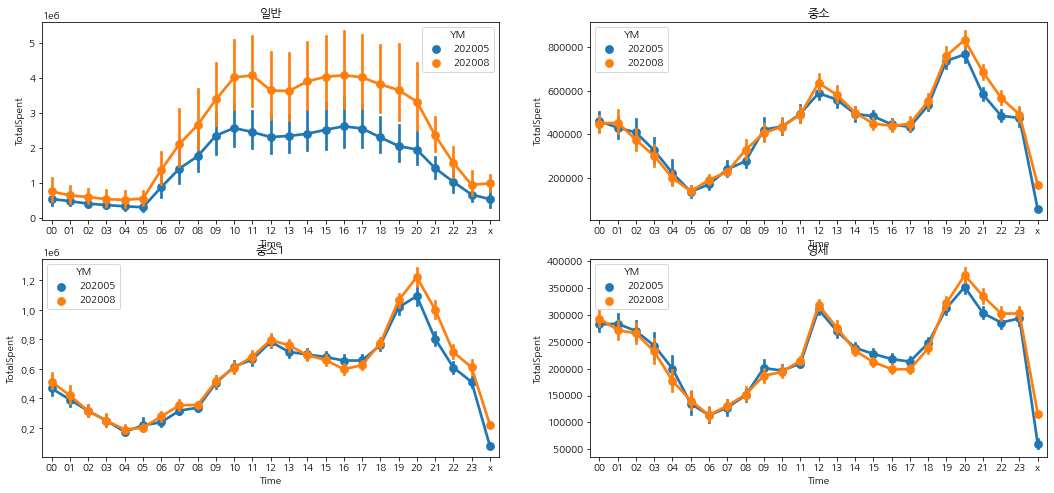

In [19]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
figure.set_size_inches(18,8)

sns.pointplot(data=df_78[df_78['FranClass']=='일반'], x=df["Time"].sort_values(), y="TotalSpent", hue='YM',ax=ax1)
sns.pointplot(data=df_78[df_78['FranClass']=='중소'], x=df["Time"].sort_values(), y="TotalSpent",hue='YM', ax=ax2)
sns.pointplot(data=df_78[df_78['FranClass']=='중소1'], x=df["Time"].sort_values(), y="TotalSpent",hue='YM', ax=ax3)
sns.pointplot(data=df_78[df_78['FranClass']=='영세'], x=df["Time"].sort_values(), y="TotalSpent",hue='YM', ax=ax4)
ax1.set_title("일반")
ax2.set_title("중소")
ax3.set_title("중소1")
ax4.set_title("영세")

plt.show();
# 일반업종을 제외하면 총사용금액이 비슷함을 알 수 있다.(재난지원금의 덕분?)

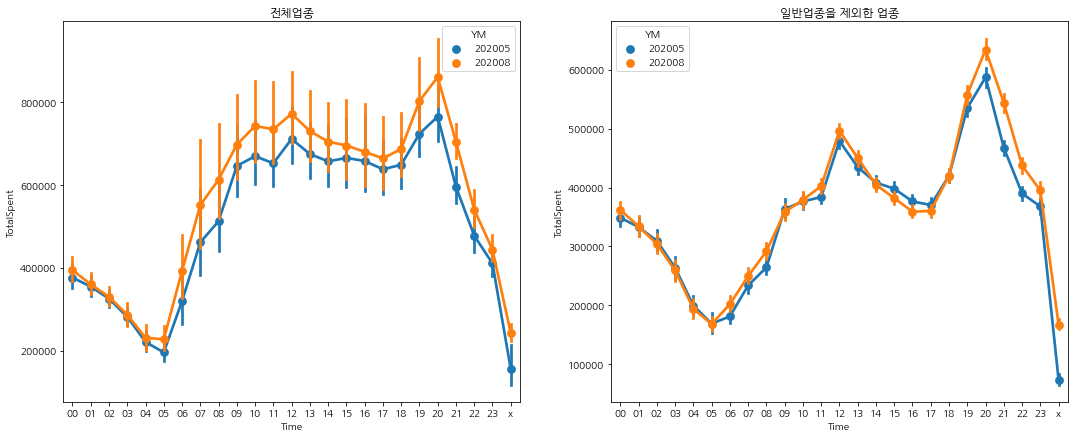

In [20]:
fig,(ax1,ax2)= plt.subplots(ncols=2, constrained_layout=True)
fig.set_size_inches(18,7)
sns.pointplot(data=df_78, x=df["Time"].sort_values(), y="TotalSpent", hue='YM', ax=ax1)
sns.pointplot(data=df_78[df_78['FranClass']!='일반'], x=df["Time"].sort_values(), y="TotalSpent", hue='YM', ax=ax2)
ax1.set_title("전체업종")
ax2.set_title("일반업종을 제외한 업종");

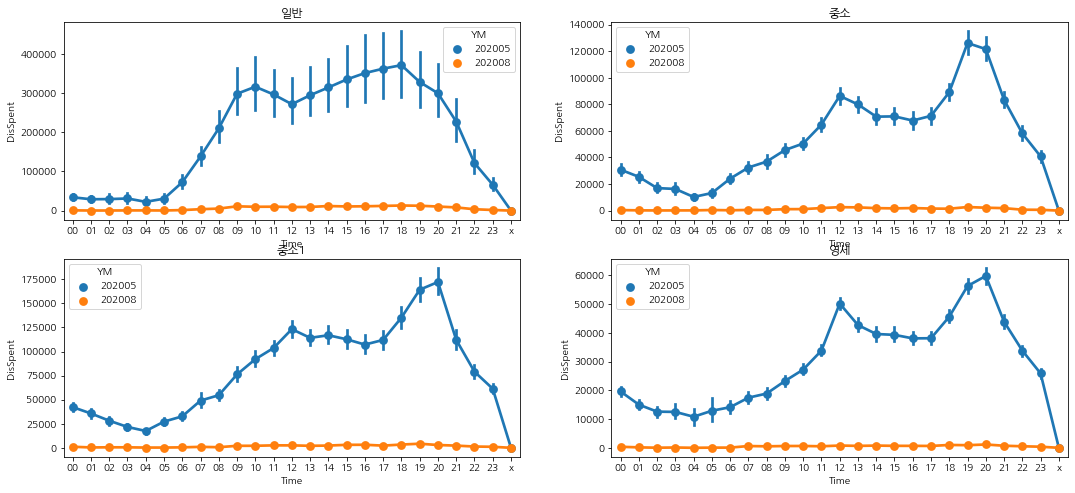

In [21]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
figure.set_size_inches(18,8)

sns.pointplot(data=df_78[df_78['FranClass']=='일반'], x=df["Time"].sort_values(), y="DisSpent", hue='YM',ax=ax1)
sns.pointplot(data=df_78[df_78['FranClass']=='중소'], x=df["Time"].sort_values(), y="DisSpent",hue='YM', ax=ax2)
sns.pointplot(data=df_78[df_78['FranClass']=='중소1'], x=df["Time"].sort_values(), y="DisSpent",hue='YM', ax=ax3)
sns.pointplot(data=df_78[df_78['FranClass']=='영세'], x=df["Time"].sort_values(), y="DisSpent",hue='YM', ax=ax4)
ax1.set_title("일반")
ax2.set_title("중소")
ax3.set_title("중소1")
ax4.set_title("영세")

fig.tight_layout()
plt.show();

In [22]:
df['DisSpent'].sum()/df['TotalSpent'].sum()

0.05101703265342923

In [23]:
df_78['DisSpent'].sum()/df_78['TotalSpent'].sum()

0.06981074659327222

In [24]:
def df_time(a,b,c):
    """a는 해당월 하나를 입력
    b는 DisSpent or TotalSpent
    c는 시간을 문자열로"""
    df_temp= df[df['YM']==a].groupby(['Time','category'])[b].sum()
    df_temp=pd.DataFrame(df_temp).sort_values(b, ascending=False)
    df_temp.reset_index(inplace=True)
    return df_temp[df_temp['Time']==c].reset_index().head(10)

In [25]:
# 전체 5월 시간별, 상위 10개 총사용금액을 보여줌  
df_total=[]
for i in range(24):
    if i < 10:
        i= '0'+ str(i)
        df_temp = df_time(202005, 'TotalSpent', i)
        df_total.append(df_temp)
    else:
        df_temp = df_time(202005, 'TotalSpent', str(i))
        df_total.append(df_temp)

pd.options.display.max_columns = len(pd.concat(df_total, axis=1).drop(['index'], axis=1).columns)    
pd.concat(df_total, axis=1).drop(['index'], axis=1)

,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent,Time,category,TotalSpent
0,00,외식/주점,1234724086,01,외식/주점,941881755,02,외식/주점,648289199,03,외식/주점,395301632,04,외식/주점,199154673,05,외식/주점,122561030,06,마트/편의점(유통),245095630,07,마트/편의점(유통),540649540,08,마트/편의점(유통),962768398,09,마트/편의점(유통),1520952083,10,마트/편의점(유통),2118171396,11,마트/편의점(유통),2422070209,12,외식/주점,4191624208,13,외식/주점,3480137016,14,마트/편의점(유통),2939847297,15,마트/편의점(유통),3325681217,16,마트/편의점(유통),3645316408,17,마트/편의점(유통),3815247734,18,마트/편의점(유통),3730148771,19,외식/주점,5158193724,20,외식/주점,5551439137,21,외식/주점,3345747733,22,외식/주점,2025980400,23,외식/주점,1570960844
1,00,마트/편의점(유통),285018780,01,마트/편의점(유통),182364840,02,마트/편의점(유통),129337990,03,마트/편의점(유통),88656180,04,마트/편의점(유통),71499320,05,마트/편의점(유통),105561180,06,주유/자동차,161722143,07,주유/자동차,368714214,08,주유/자동차,584493189,09,의료,1083517209,10,의료,1712332574,11,외식/주점,1811382854,12,마트/편의점(유통),2506110222,13,마트/편의점(유통),2643153751,14,외식/주점,2436597718,15,외식/주점,1662081330,16,여행/숙박,1410726859,17,외식/주점,1611600239,18,외식/주점,3061083585,19,마트/편의점(유통),3157960753,20,마트/편의점(유통),2669390848,21,마트/편의점(유통),2049517238,22,마트/편의점(유통),1198014841,23,마트/편의점(유통),543953105
2,00,레저/스포츠,79010765,01,레저/스포츠,46410400,02,여행/숙박,29416870,03,여행/숙박,20886520,04,주유/자동차,13490027,05,주유/자동차,33692108,06,여행/숙박,132280024,07,여행/숙박,322668323,08,여행/숙박,531513847,09,주유/자동차,852027054,10,여행/숙박,1097926966,11,의료,1682255593,12,의료,1106167569,13,여행/숙박,1174112651,14,여행/숙박,1223188431,15,여행/숙박,1352076958,16,외식/주점,1306556139,17,여행/숙박,1204127124,18,레저/스포츠,998301578,19,여행/숙박,857039688,20,여행/숙박,834957365,21,카페/베이커리,327245340,22,카페/베이커리,221968510,23,카페/베이커리,127645680
3,00,여행/숙박,67986577,01,여행/숙박,42375310,02,레저/스포츠,22098700,03,레저/스포츠,13371215,04,여행/숙박,13332510,05,레저/스포츠,16312200,06,외식/주점,116745900,07,외식/주점,174106927,08,외식/주점,277733439,09,여행/숙박,799815088,10,주유/자동차,970773798,11,여행/숙박,1114315878,12,여행/숙박,1018556008,13,레저/스포츠,1015214342,14,주유/자동차,1114407811,15,의료,1173712125,16,주유/자동차,1103397896,17,레저/스포츠,1194432830,18,여행/숙박,973582771,19,레저/스포츠,619477755,20,레저/스포츠,431556164,21,여행/숙박,324457831,22,여행/숙박,187307643,23,여행/숙박,117118915
4,00,쇼핑/패션,61447468,01,쇼핑/패션,33765140,02,의료,11730970,03,쇼핑/패션,7731500,04,레저/스포츠,7093900,05,여행/숙박,14118825,06,레저/스포츠,84423600,07,레저/스포츠,157174315,08,의료,232917880,09,교육/육아,727277270,10,외식/주점,824610480,11,주유/자동차,1025806069,12,레저/스포츠,1002990280,13,주유/자동차,938108112,14,의료,1114041993,15,주유/자동차,1121299209,16,의료,1049476090,17,주유/자동차,1058438849,18,주유/자동차,787087732,19,카페/베이커리,469263974,20,카페/베이커리,416706974,21,쇼핑/패션,242227332,22,레저/스포츠,159858061,23,레저/스포츠,109037758
5,00,카페/베이커리,53769920,01,카페/베이커리,21165200,02,쇼핑/패션,10789221,03,주유/자동차,6907088,04,쇼핑/패션,6583992,05,의료,7881000,06,서비스/기타,42976172,07,건설/제조,116704590,08,교육/육아,223011610,09,외식/주점,481530480,10,교육/육아,755158780,11,레저/스포츠,716327541,12,주유/자동차,872334259,13,쇼핑/패션,690376225,14,레저/스포츠,876490376,15,쇼핑/패션,977625350,16,레저/스포츠,998166912,17,의료,783009557,18,교육/육아,488138540,19,주유/자동차,444554285,20,쇼핑/패션,374755406,21,레저/스포츠,242105923,22,쇼핑/패션,158117585,23,쇼핑/패션,106600239
6,00,교육/육아,19426150,01,의료,8171340,02,카페/베이커리,8680150,03,의료,5332160,04,교육/육아,4616000,05,생활/기타,6773800,06,건설/제조,19266870,07,서비스/기타,55271600,08,건설/제조,206926054,09,건설/제조,238165603,10,레저/스포츠,341585375,11,교육/육아,606168540,12,교육/육아,559473450,13,교육/육아,628517327,14,쇼핑/패션,825837582,15,레저/스포츠,792442261,16,쇼핑/패션,784462946,17,쇼핑/패션,727379635,18,카페/베이커리,461546435,19,쇼핑/패션,394274100,20,주유/자동차,265970276,21,교육/육아,189992480,22,교육/육아,106725320,23,교육/육아,51919500
7,00,의료,16156030,01,주유/자동차,7198375,02,주유/자동차,699

In [26]:
df_nw = df_78[df_78['dong'].str.contains('남원')]
df_ps = df_78[df_78['dong'].str.contains('표선')]
df_ss = df_78[df_78['dong'].str.contains('성산')]

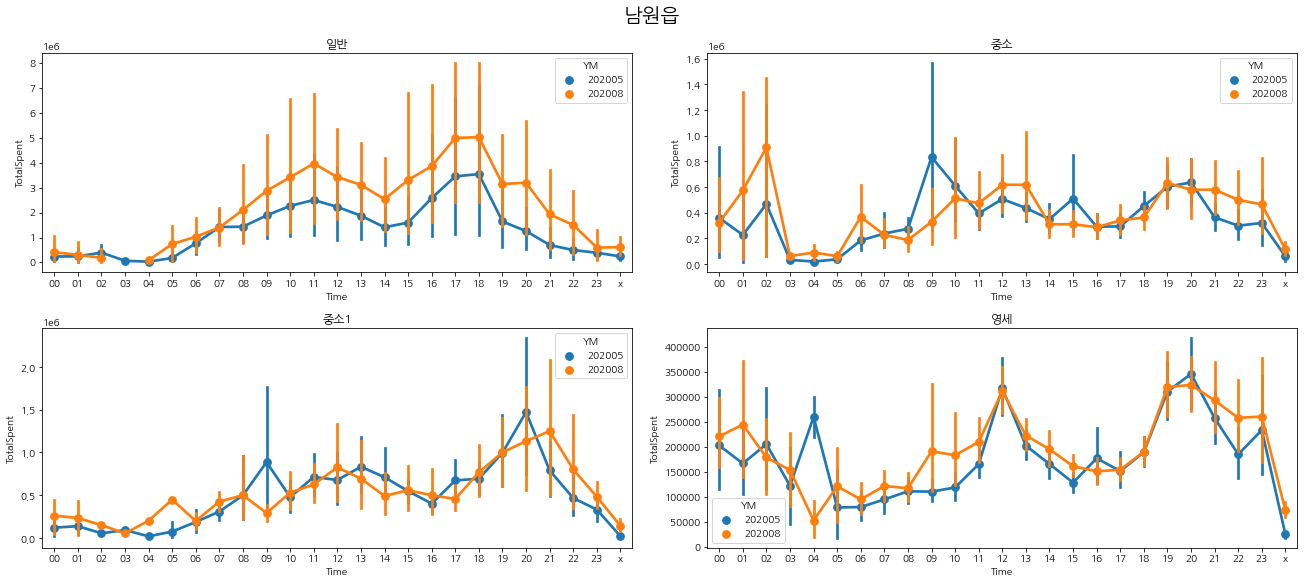

In [27]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
figure.set_size_inches(18,8)

sns.pointplot(data=df_nw[df_nw['FranClass']=='일반'], x=df["Time"].sort_values(), y="TotalSpent", hue='YM',ax=ax1)
sns.pointplot(data=df_nw[df_nw['FranClass']=='중소'], x=df["Time"].sort_values(), y="TotalSpent",hue='YM', ax=ax2)
sns.pointplot(data=df_nw[df_nw['FranClass']=='중소1'], x=df["Time"].sort_values(), y="TotalSpent",hue='YM', ax=ax3)
sns.pointplot(data=df_nw[df_nw['FranClass']=='영세'], x=df["Time"].sort_values(), y="TotalSpent",hue='YM', ax=ax4)
ax1.set_title("일반")
ax2.set_title("중소")
ax3.set_title("중소1")
ax4.set_title("영세")
plt.suptitle('남원읍',fontsize=20)
fig.tight_layout()
plt.show();

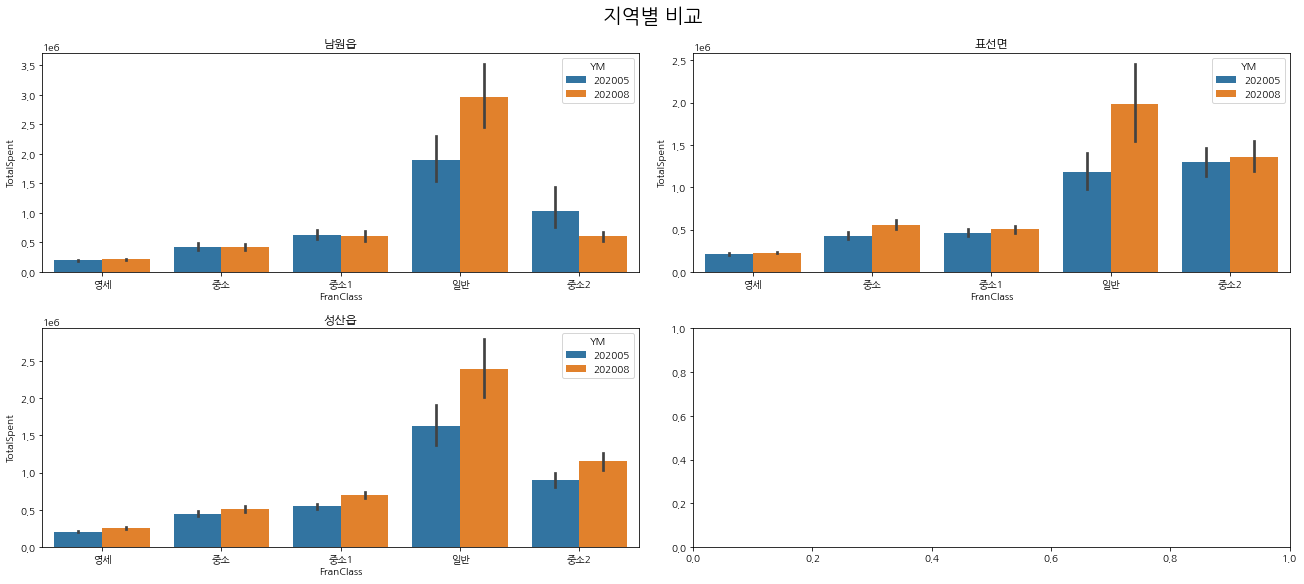

In [28]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
figure.set_size_inches(18,8)

sns.barplot(data=df_nw, x=df["FranClass"], y="TotalSpent", hue='YM',ax=ax1)
sns.barplot(data=df_ps, x=df["FranClass"], y="TotalSpent",hue='YM', ax=ax2)
sns.barplot(data=df_ss, x=df["FranClass"], y="TotalSpent",hue='YM', ax=ax3)

ax1.set_title("남원읍")
ax2.set_title("표선면")
ax3.set_title("성산읍")

plt.suptitle('지역별 비교',fontsize=20)
fig.tight_layout()
plt.show();

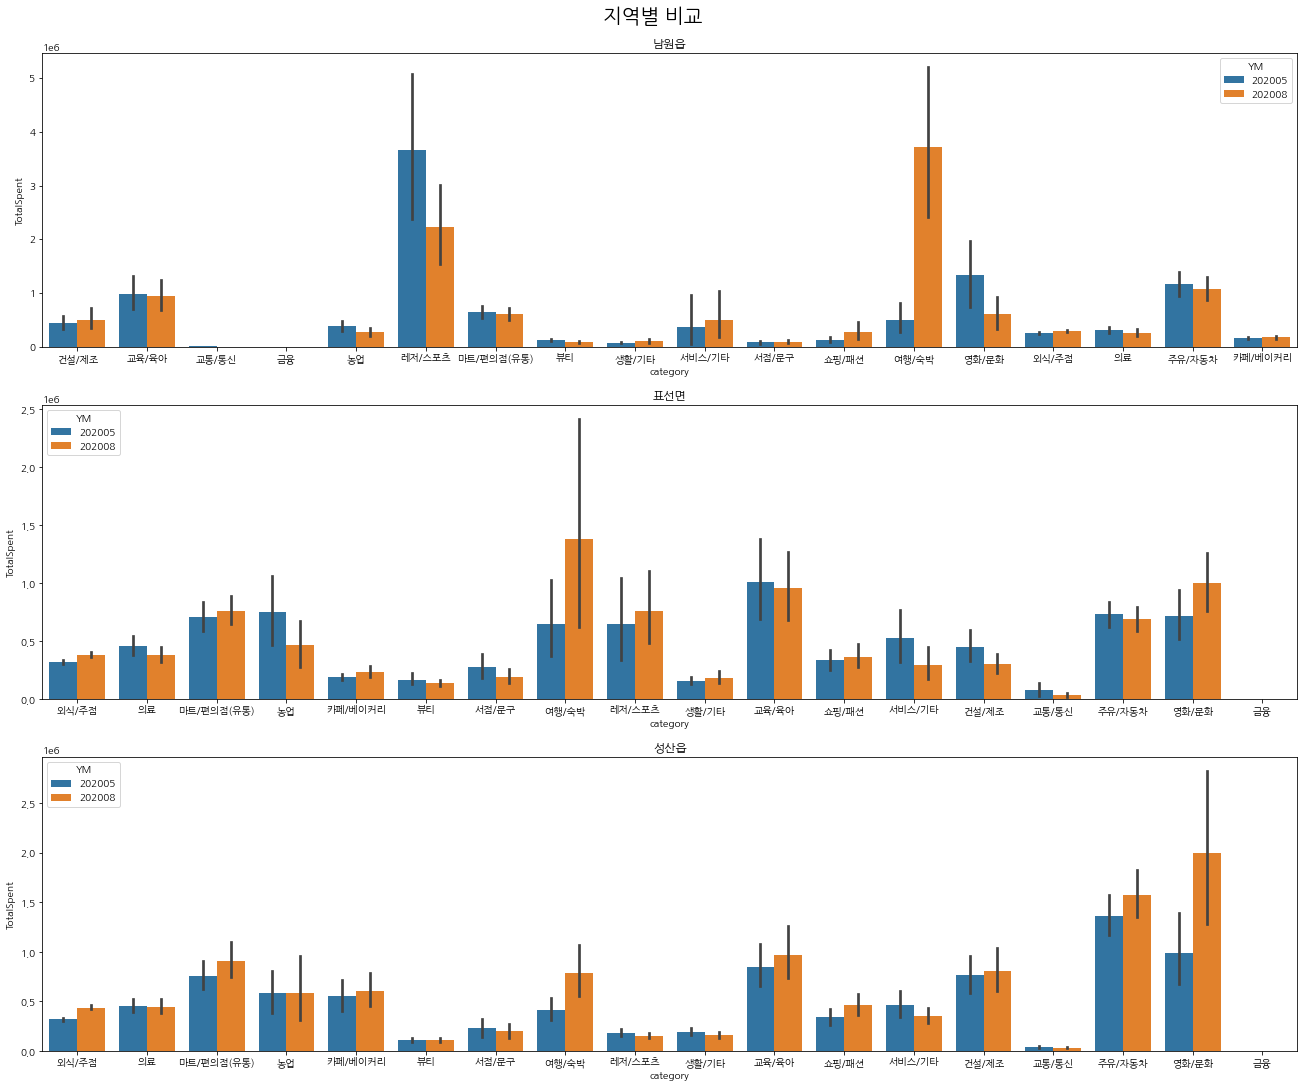

In [29]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=3,constrained_layout=True)

figure.set_size_inches(18,15)

sns.barplot(data=df_nw, x=df["category"].sort_values(), y="TotalSpent", hue='YM',ax=ax1)
sns.barplot(data=df_ps, x=df["category"], y="TotalSpent",hue='YM', ax=ax2)
sns.barplot(data=df_ss, x=df["category"], y="TotalSpent",hue='YM', ax=ax3)

ax1.set_title("남원읍")
ax2.set_title("표선면")
ax3.set_title("성산읍")

plt.suptitle('지역별 비교',fontsize=20)

plt.show();

<AxesSubplot:xlabel='FranClass', ylabel='TotalSpent'>

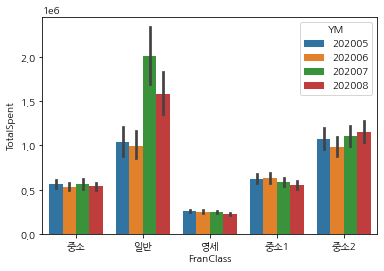

In [30]:
figure.set_size_inches(18,15)
sns.barplot(data=df[df['dong']=='아라일동'], x="FranClass", y="TotalSpent", hue='YM')

In [31]:
df_x = df[df['Time']=='x']

<AxesSubplot:xlabel='category', ylabel='TotalSpent'>

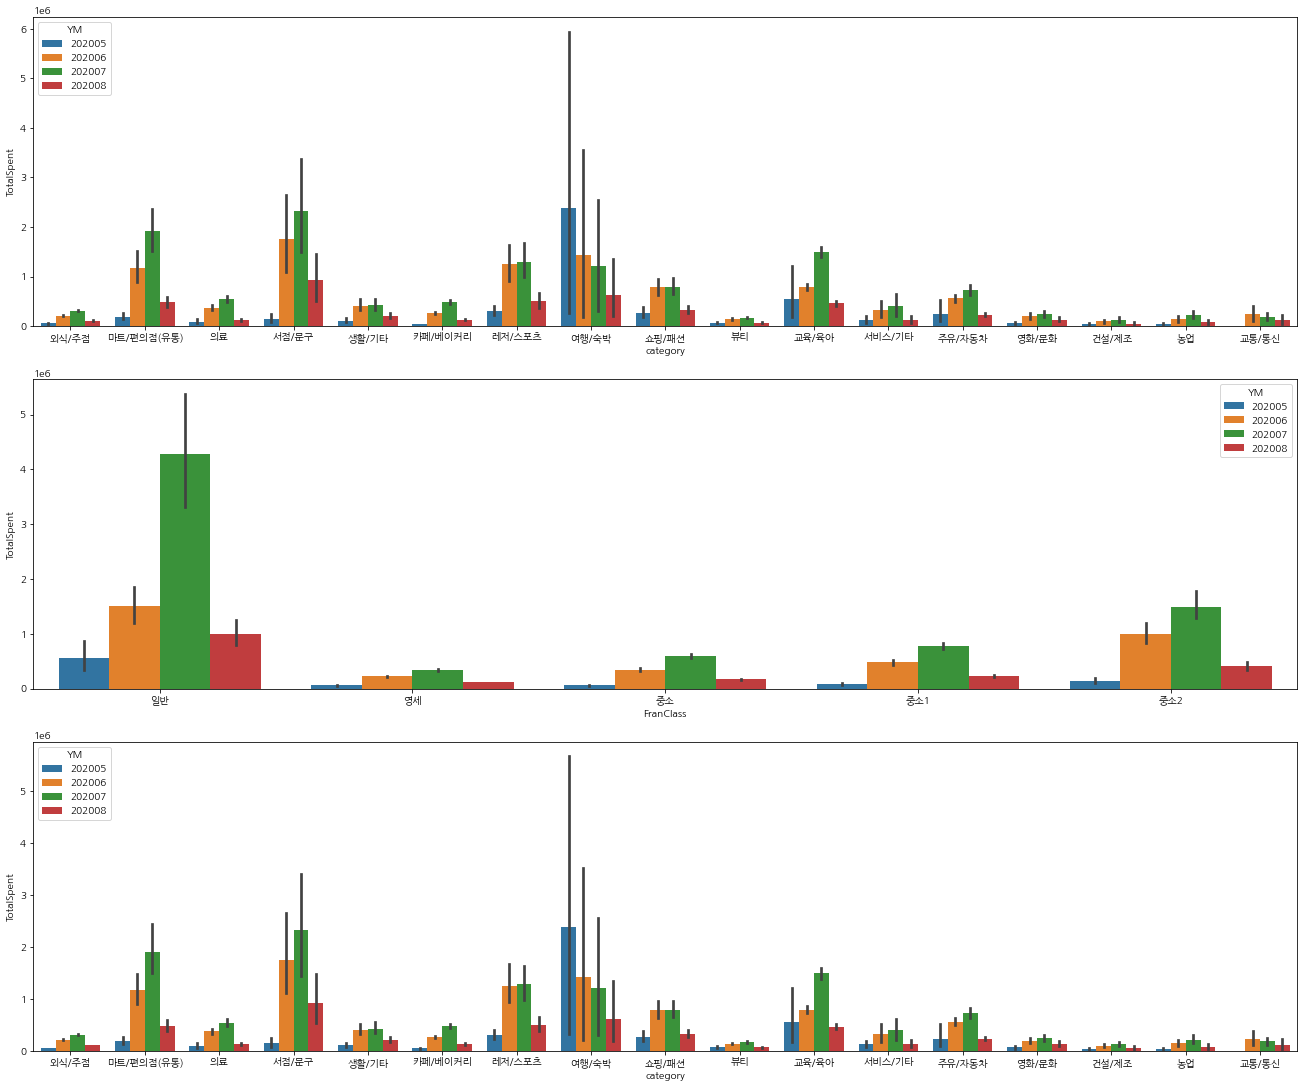

In [32]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=3,constrained_layout=True)

figure.set_size_inches(18,15)

sns.barplot(data=df_x, x=df_x["category"], y="TotalSpent", hue='YM',ax=ax1)
sns.barplot(data=df_x, x=df_x["FranClass"], y="TotalSpent",hue='YM', ax=ax2)
sns.barplot(data=df_x, x=df_x["category"], y="TotalSpent",hue='YM', ax=ax3)